<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [373]:
%%capture
pip install pyswarms

In [374]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [375]:
MAX_VALUE_CUSTO = 100
fator_melhoria = 'expo'

In [376]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [377]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [378]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [379]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [380]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [381]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [382]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [383]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [384]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [385]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


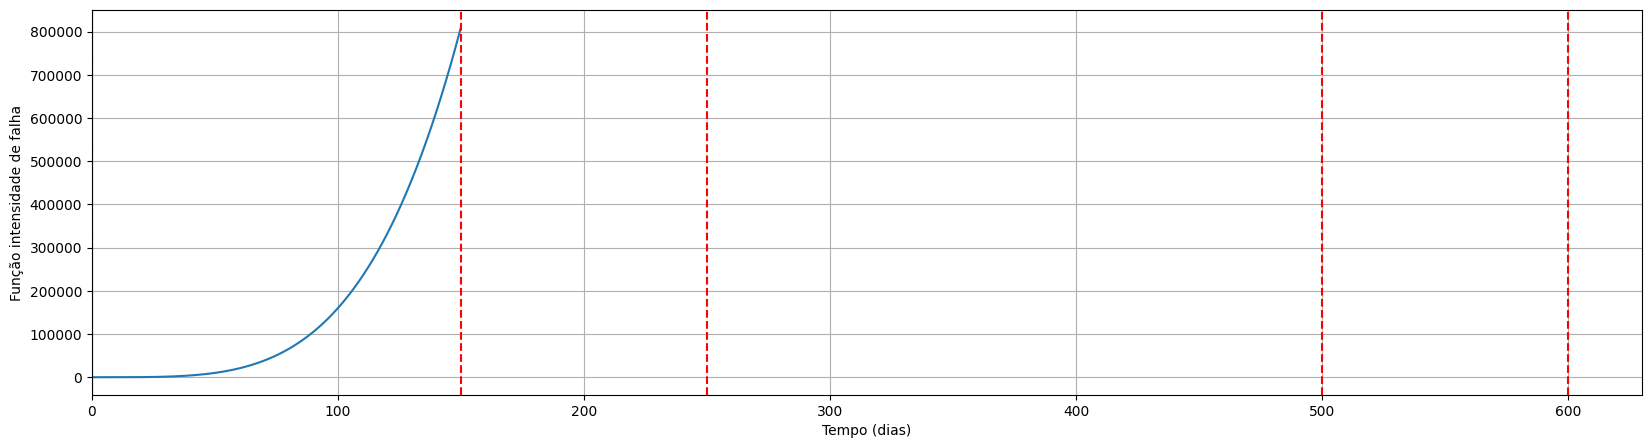

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [386]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [387]:
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1:0.25, 3:0.50, 5:0.75, 7:1.0}

    # Criação de variáveis para os parâmetros
    lamb = x[0]
    beta = x[1]
    theta = x[2]

    # Cálculo da intensidade de falha
    # Cria as variaveis
    # tempos de falhas
    t = df['t']
    # indice do sistema
    k = df['k']
    m = k.drop_duplicates().shape[0]
    # Numero de ciclos de manutenção
    ck = df['c'].max()
    # Numero de falhas e severidade das manutenções preventivas em cada sistema
    n = []
    s = []

    for k in range(m):
        n.append(list(df['n'][k * ck:(k + 1) * ck]))
        s.append(list(df['s'][k * ck:(k + 1) * ck]))

    # Tempos das MP
    T = list(df['T'][:m])

        # Obter o número de ciclos de manutenção
    num_ciclos = ck

    # Obter os tempos para manutenções preventivas
    tempos_mp = T

    # Cria alguns cenários de teste
    beta = 5

    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    termos_somatorio = [((1 / (lamb ** beta)) * (T[1] ** beta))]
    numero_medio_falhas = [0, ((1 / (lamb ** beta)) * (T[1] ** beta))]

    for i in range(ck - 1):
        termo = (((T[i + 2] - fator[i] * T[i + 1]) ** beta) - (((1 - fator[i]) * T[i + 1]) ** beta)) * (1 / (lamb ** beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    final = 730
    termo = (((final - fator[ck - 1] * T[ck]) ** beta) - (((1 - fator[ck - 1]) * T[ck]) ** beta)) * (1 / (lamb ** beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    Ctotal = []
    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i + 1] - mi[i]) * CMC) / (T[i + 1] - T[i]))

    cmp = custo_mp(s[0][ck - 1], CMP)
    Ctotal.append((cmp + (mi[ck + 1] - mi[ck]) * CMC) / (final - T[ck]))

    Custo = np.sum(np.minimum(Ctotal, MAX_VALUE_CUSTO))

    print("")
    print("=========================================================================")
    print("")

    print('Media de falhas:', mi)

    print('Fator:', fator)

     # Imprimir o custo total para manutenções preventivas
    print("Custo Total:", Custo)

     # Imprimir o número de ciclos de manutenção
    print("Número de Ciclos de Manutenção:", num_ciclos)

    # Imprimir os tempos para manutenções preventivas
    print("Tempos para Manutenções Preventivas:", tempos_mp)

    # Imprimir a severidade para cada ciclo de manutenção
    print("=========================================================================")
    print("")
    for k in range(m):

        for i in range(num_ciclos):
            if not np.isnan(s[k][i]):
                print("Severidade para Ciclo de Manutenção", i+1, "do Sistema", k+1, ":", s[k][i])

    return Custo

In [388]:
num_particles = 100
max_iterations = 100
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Lista para armazenar o custo em cada iteração
cost_history = []

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)
    cost_history.append(best_cost)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-07-05 23:10:00,151 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   5%|▌         |5/100, best_cost=-1.49e+23



Media de falhas: [0, array([7.63174063e+10, 1.50740212e+17, 1.22429564e+12]), array([3.92020090e+11, 7.74308171e+17, 6.28884696e+12]), array([1.53679280e+13, 4.06904991e+19, 4.26896822e+14]), array([2.70142273e+13, 8.28362817e+19, 9.93621751e+14]), array([3.86934492e+13, 1.47498304e+20, 2.26360617e+15])]
Fator: [0.3296799539643607, array([0.2706944 , 0.16148807, 0.06046435]), array([0.32603564, 0.19760806, 0.07500033]), array([0.50847402, 0.32718479, 0.13092983]), array([0.14600609, 0.08429703, 0.03070353])]
Custo Total: 1500.0
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para 

pyswarms.single.global_best:  10%|█         |10/100, best_cost=-1.49e+23

1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 2.49276611e+14, -4.00364027e+13, -1.69459014e+11]

pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=-1.49e+23


Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 3.02359396e+12, -5.85075684e+17, -1.27783987e+12]), array([ 1.55313137e+13, -3.00536186e+18, -6.56388789e+12]), array([ 7.72638381e+14, -3.42116468e+20, -2.45499091e+15]), array([ 1.52932187e+15, -1.05039909e+21, -1.39669296e+16]), array([ 2.60037507e+15, -4.44970762e+21, -3.04843713e+17])]
Fator: [0.3296799539643607, array([ 0.18242453, -0.16151833, -0.78328584]), array([ 0.22257264, -0.20582028, -1.06075424]), array([ 0.36439446, -0.40058235, -2.67491387]), array([ 0.0958012 , -0.0777376 , -0.33539726])]
Custo Total: -1.3847305467750437e+23
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Man

pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=-1.57e+23

3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 4.98208633e+12, -4.09567955e+17,  4.67238592e+13]), array([ 2.55915135e+13, -2.10383023e+18,  2.40006735e+14]), array([ 1.00663703e+15, -2.83122627e+20,  1.16978791e+16]), array([ 1.77240385e+15, -9.50793954e+20,  2.29141915e+16]), array([ 2.54403657e+15, -5.03421662e+21,  3.83215008e+16])]
Fator: [0.3296799539643607, array([ 0.26947003, -0.23903947,  0.19017527]), array([ 0.32462101, -0.

pyswarms.single.global_best:  19%|█▉        |19/100, best_cost=-2.49e+25

 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidad

pyswarms.single.global_best:  22%|██▏       |22/100, best_cost=-2.49e+25

4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([2.14081344e+13, 1.91332015e+16, 2.67814592e+13]), array([1.09967295e+14, 9.82816336e+16, 1.37568486e+14]), array([4.95179009e+15, 8.36774440e+18, 8.91123682e+15]), array([9.31981746e+15, 2.19795903e+19, 2.02338595e+16]), array([1.46656682e+16, 6.46411820e+19, 4.39048282e+16])]
Fator: [0.3296799539643607, array([ 0.21986542, -0.03370122,  0.07935547]), array([ 0.26681781, -0.04230252,  0.09819015]), array([ 0.42801922, -0.07742938,  0.16975369]), array([ 0.11674773, -0.01671098,  0.04049777])]
Custo Total: 1500.0
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 

pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=-4.66e+25

 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 2.80676623e+13, -2.98549385e+16, -6.27832828e+14]), array([ 1.44175333e+14, -1.53356046e+17, -3.22499274e+15]), array([ 7.23124705e+15, -1.55854332e+19, -2.06848302e+17]), array([ 1.43731051e+16, -4.50228892e+19, -4.67224468e+17]), array([ 2.46042182e+16, -1.6473

pyswarms.single.global_best:  30%|███       |30/100, best_cost=-4.66e+25

Custo Total: -5.292705029464121e+22
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Sev

pyswarms.single.global_best:  35%|███▌      |35/100, best_cost=-4.66e+25

 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 2.74888226e+13, -3.45192703e+16, -6.45964741e+17]), array([ 1.41202004e+14, -1.77315348e+17, -3.31813105e+18]), array([ 7.90592232e+15, -1.56501835e+19, -2.27943770e+20]), array([ 1.66310699e+16, -4.19104639e+19, -5.33917623e+20]), array([ 3.13300167e+16, -1.28705426e+20, -1.23182343e+21])]
Fator: [0.3296799539643607, array([ 0.13697768, -0.04910236,  0.05561899]), array([ 0.1681835 , -0.06175015,  0.0690335 ]), array([ 0.28212379, -0.11388459,  0.12081291]), array([ 0.07101006, -0.02425698,  0.02820732])]
Custo Total: -4.1406325152218905e+22
Número de Ciclos de Manutenção: 4
Tempos para Manutençõe

pyswarms.single.global_best:  44%|████▍     |44/100, best_cost=-4.66e+25

4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 2.61830802e+13, -3.85562265e+17,  5.73477989e+15]), array([ 1.34494789e+14, -1.98052006e+18,  2.94578791e+16]), array([ 7.42156283e+15, -1.59788214e+20,  2.29904387e+18]), array([ 1.54946608e+16, -4.07784137e+20,  5.76390925e+18]), array([ 2.88058084e+16, -1.12561826e+21,  1.53122309e+19])]
Fator: [0.3296799539643607, array([ 0.1426345 , -0.0109094 ,  0.00301976]), array([ 0.17499324, -0.01365529,  0.00377328]), array([ 0.29266767, -0.02471366,  0.00678165]), array([ 0.07405967, -0.0054399 ,  0.00151102])]
Custo Total: -3.460604364228875e+22
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidad

pyswarms.single.global_best:  44%|████▍     |44/100, best_cost=-4.66e+25


Fator: [0.3296799539643607, array([ 0.20086659, -0.0806816 ,  0.11590651]), array([ 0.24443104, -0.10184929,  0.1427199 ]), array([ 0.3961996 , -0.19074826,  0.24208424]), array([ 0.10605738, -0.03955837,  0.05973754])]
Custo Total: -5.658122006223344e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade

pyswarms.single.global_best:  48%|████▊     |48/100, best_cost=-4.66e+25

do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de f

pyswarms.single.global_best:  51%|█████     |51/100, best_cost=-4.66e+25

 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 2.64896616e+13, -8.13100524e+16,  2.68185528e+18]), array([ 1.36069607e+14, -4.17665846e+17,  1.37759025e+19]), array([ 6.38617852e+15, -3.33374241e+19,  9.03037867e+20]), array([ 1.22723360e+16, -8.45905160e+19,  2.06336583e+21]), array([ 1.99236069e+16, -2.30607055e+20,  4.53231741e+21])]
Fator: [0.3296799539643607, array([ 0.20439983, -0.00639452,  0.07457296]), array([ 0.24860452, -0.00799953,  0.09233053]), array([ 0.40218963, -0.0144452 ,  0.16001813]), array([ 0.10803578, -0.00319217,  0.03800882])]
Custo Total: -7.08527888292266e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de M

pyswarms.single.global_best:  55%|█████▌    |55/100, best_cost=-9.02e+30

Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 2.82523106e+13, -2.93652713e+16, -3.44811930e+18]), array([ 1.45123817e+14, -1.50840770e+17, -1.77119756e+19]), array([ 6.94203084e+15, -1.10436277e+19, -1.12750178e+21]), array([ 1.34695938e+16, -2.67587903e+19, -2.53667558e+21]), array([ 2.21937956e+16, -6.61541236e+19, -5.40752154e

pyswarms.single.global_best:  58%|█████▊    |58/100, best_cost=-9.02e+30

0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 2.78511652e+13, -3.21760642e+16, -9.85594789e+18]), array([ 1.43063251e+14, -1.65278987e+17, -5.06271081e+19]), array([ 7.66038108e+15, -1.28817820e+19, -3.81606712e+21]), array([ 1.57462121e+16, -3.22724332e+19, -9.39100253e+21]), array([ 2.84993948e+16, -8.56014167e+19, -2.39824228e+22])]
Fator: [0.3296799539643607, array([0.15427278, 0.00358512, 0.01751055]), array([0.18896819, 0.00447939, 0.02184006]), array([0.31408832, 0.00804845, 0.03896818]), array([0.08036571, 0.00179417, 0.00879394])]
Custo Tot

pyswarms.single.global_best:  62%|██████▏   |62/100, best_cost=-9.02e+30

Fator: [0.3296799539643607, array([ 0.15948222, -0.01198684,  0.08020784]), array([ 0.19520803, -0.01500594,  0.0992337 ]), array([ 0.32355804, -0.02717265,  0.17148222]), array([ 0.08320243, -0.00597557,  0.04094205])]
Custo Total: -8.957691913899466e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade 

pyswarms.single.global_best:  65%|██████▌   |65/100, best_cost=-9.02e+30

: 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 2.79807154e+13, -2.47113831e+16, -4.35378775e+19]), array([ 1.43728713e+14, -1.26935113e+17, -2.23641283e+20]), array([ 7.02408978e+15, -9.95429383e+18, -1.62851596e+22]), array([ 1.37777662e+16, -2.50203952e+19, -3.93453208e+22]), array([ 2.30914125e+16, -6.68347161e+19, -9.66909420e+22])]
Fator: [0.3296799539643607, array([0.1891627 , 0.00101397, 0.03177816]), array([0.23057348, 0.0012673 , 0.03956364]), array([0.37612028, 0.00227998, 0.07008454]), array([0.09953495, 0.00050711, 0.01601736])]
Custo Total: -2.9542877647003474e+24
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção

pyswarms.single.global_best:  68%|██████▊   |68/100, best_cost=-9.02e+30



Media de falhas: [0, array([ 2.76848628e+13, -3.43673763e+16, -3.28421317e+18]), array([ 1.42209005e+14, -1.76535113e+17, -1.68700380e+19]), array([ 7.27252450e+15, -1.39425949e+19, -1.08526920e+21]), array([ 1.45995681e+16, -3.51784615e+19, -2.45525160e+21]), array([ 2.53997600e+16, -9.47390150e+19, -5.29015748e+21])]
Fator: [0.3296799539643607, array([ 0.17191199, -0.00195957,  0.08212449]), array([ 0.21005724, -0.00245007,  0.10157935]), array([ 0.34585787, -0.00441444,  0.17536169]), array([ 0.09000659, -0.00097931,  0.0419418 ])]
Custo Total: -1.626614951740471e+23
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:  73%|███████▎  |73/100, best_cost=-9.02e+30

 5 : 0.2


Media de falhas: [0, array([ 2.72518454e+13, -6.28031427e+16,  4.17283520e+25]), array([ 1.39984722e+14, -3.22601289e+17,  2.14346282e+26]), array([ 7.02387256e+15, -2.49335934e+19,  1.66599257e+28]), array([ 1.39637739e+16, -6.21863571e+19,  4.16760584e+28]), array([ 2.39114124e+16, -1.63377031e+20,  1.10195313e+29])]
Fator: [0.3296799539643607, array([0.17916247, 0.00708385, 0.00474055]), array([0.21869338, 0.00884696, 0.00592218]), array([0.35867421, 0.01586814, 0.01063466]), array([0.09399916, 0.00354822, 0.00237309])]
Custo Total: -5.009512309140779e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenç

pyswarms.single.global_best:  77%|███████▋  |77/100, best_cost=-9.02e+30

 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 2.75988222e+13, -3.85273426e+16, -1.95690767e+20]), 

pyswarms.single.global_best:  79%|███████▉  |79/100, best_cost=-9.02e+30

 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade pa

pyswarms.single.global_best:  83%|████████▎ |83/100, best_cost=-9.02e+30



Media de falhas: [0, array([ 2.72569528e+13, -5.50775562e+16,  2.85461675e+20]), array([ 1.40010957e+14, -2.82917221e+17,  1.46633274e+21]), array([ 6.85548005e+15, -2.05166613e+19,  9.64450391e+22]), array([ 1.34601082e+16, -4.94598602e+19,  2.20761196e+23]), array([ 2.25937201e+16, -1.20996211e+20,  4.86605242e+23])]
Fator: [0.3296799539643607, array([0.18844018, 0.03347703, 0.073218  ]), array([0.22971637, 0.04166969, 0.09066902]), array([0.37486876, 0.07375174, 0.15724842]), array([0.09913385, 0.016881  , 0.03730483])]
Custo Total: -3.693168653563364e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do S

pyswarms.single.global_best:  85%|████████▌ |85/100, best_cost=-9.02e+30



Media de falhas: [0, array([ 2.74629901e+13, -4.08066421e+16, -1.64832199e+20]), array([ 1.41069310e+14, -2.09611729e+17, -8.46694569e+20]), array([ 7.29684607e+15, -1.65444834e+19, -6.07642619e+22]), array([ 1.47342134e+16, -4.17291357e+19, -1.45674956e+23]), array([ 2.58821106e+16, -1.12298770e+20, -3.52323620e+23])]
Fator: [0.3296799539643607, array([ 0.16755907, -0.00169434,  0.03775915]), array([ 0.20486333, -0.00211837,  0.04697403]), array([ 0.33809568, -0.00381629,  0.08295948]), array([ 0.08761799, -0.00084681,  0.01906124])]
Custo Total: -1.0748647262452297e+25
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best:  90%|█████████ |90/100, best_cost=-9.02e+30



Media de falhas: [0, array([ 2.75340316e+13, -5.19613475e+16, -4.53887144e+23]), array([ 1.41434229e+14, -2.66910173e+17, -2.33148488e+24]), array([ 7.08205718e+15, -2.26452873e+19, -1.56113794e+26]), array([ 1.40646960e+16, -5.93706668e+19, -3.60737026e+26]), array([ 2.40434991e+16, -1.73878916e+20, -8.10067473e+26])]
Fator: [0.3296799539643607, array([ 0.17994274, -0.03220739,  0.06600584]), array([ 0.21962163, -0.04042003,  0.08181499]), array([ 0.36004505, -0.07392924,  0.14242056]), array([ 0.09442987, -0.01597608,  0.03356627])]
Custo Total: -2.455821137536212e+28
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:  90%|█████████ |90/100, best_cost=-9.02e+30



Media de falhas: [0, array([ 2.72671286e+13, -4.17823043e+16, -9.15291336e+24]), array([ 1.40063227e+14, -2.14623419e+17, -4.70158263e+25]), array([ 7.44161750e+15, -1.66316827e+19, -3.31380729e+27]), array([ 1.52352495e+16, -4.15389875e+19, -7.86855141e+27]), array([ 2.73874007e+16, -1.09458921e+20, -1.86607853e+28])]
Fator: [0.3296799539643607, array([0.15727028, 0.00598835, 0.04515248]), array([0.19255977, 0.00747982, 0.05611838]), array([0.31954612, 0.01342338, 0.09873697]), array([0.08199689, 0.00299867, 0.022837  ])]
Custo Total: -5.68285759511738e+29
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Si

pyswarms.single.global_best:  95%|█████████▌|95/100, best_cost=-7.38e+34

Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([ 2.74783719e+13, -4.67153569e+16, -4.47108333e+23]), array([ 1.41148322e+14, -2.39963061e+17, -2.29666412e+24]), ar

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-7.38e+34
2023-07-05 23:10:06,770 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 3.07735718e-01 -6.89529192e-02 -1.39854672e-04]
2023-07-05 23:10:06,772 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 5 : 0.2


Media de falhas: [0, array([ 2.75654963e+13, -5.15842249e+16,  7.80444721e+22]), array([ 1.41595854e+14, -2.64973005e+17,  4.00891519e+23]), array([ 7.56026242e+15, -2.24482727e+19,  2.94955873e+25]), array([ 1.55176034e+16, -5.88082646e+19,  7.16557067e+25]), array([ 2.80155845e+16, -1.71934090e+20,  1.78117935e+26])]
Fator: [0.3296799539643607, array([ 0.15536973, -0.03158854,  0.02751644]), array([ 0.19028292, -0.03964038,  0.03427642]), array([ 0.31608845, -0.0724811 ,  0.0608497 ]), array([ 0.08096231, -0.01567147,  0.01385419])]
Custo Total: -5.300038224605241e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:06,887 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.3076144  -0.06888881  0.0013657 ]




Media de falhas: [0, array([ 2.75691269e+13, -4.89454951e+16,  1.59838036e+25]), array([ 1.41614503e+14, -2.51418625e+17,  8.21041020e+25]), array([ 7.94731715e+15, -2.11307753e+19,  6.15389457e+27]), array([ 1.67381847e+16, -5.51205547e+19,  1.50987055e+28]), array([ 3.15983807e+16, -1.59633645e+20,  3.83154991e+28])]
Fator: [0.3296799539643607, array([ 0.13608026, -0.02819767,  0.01984716]), array([ 0.16710214, -0.03537046,  0.02474709]), array([ 0.2804431 , -0.06456549,  0.04410309]), array([ 0.07052717, -0.01400082,  0.00997331])]
Custo Total: -4.918852407946124e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

2023-07-05 23:10:06,898 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:07,059 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30764459 -0.06928007 -0.00072154]
2023-07-05 23:10:07,060 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75556005e+13, -4.75789385e+16, -3.88282926e+26]), array([ 1.41545022e+14, -2.44399026e+17, -1.99449529e+27]), array([ 8.18702514e+15, -2.04992188e+19, -1.47662995e+29]), array([ 1.75163842e+16, -5.34150368e+19, -3.59922829e+29]), array([ 3.40072301e+16, -1.54323297e+20, -9.00896162e+29])]
Fator: [0.3296799539643607, array([ 0.12428005, -0.02733688,  0.02494111]), array([ 0.15285734, -0.03428708,  0.03107858]), array([ 0.25814028, -0.06256126,  0.05524456]), array([ 0.06420091, -0.01357628,  0.0125493 ])]
Custo Total: -2.754102537703571e+31
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1, best_cost=-7.38e+34



Media de falhas: [0, array([ 2.75395714e+13, -4.66059546e+16, -6.46406569e+23]), array([ 1.41462686e+14, -2.39401094e+17, -3.32040059e+24]), array([ 8.41631661e+15, -2.00478560e+19, -2.47468344e+26]), array([ 1.82743052e+16, -5.21940462e+19, -6.05339451e+26]), array([ 3.64424146e+16, -1.50509826e+20, -1.52646396e+27])]
Fator: [0.3296799539643607, array([ 0.11319409, -0.02665642,  0.02218885]), array([ 0.13943095, -0.03343082,  0.0276587 ]), array([ 0.23684227, -0.06097839,  0.04923384]), array([ 0.05829627, -0.01324056,  0.01115666])]
Custo Total: -4.668770580963421e+28
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:07,105 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30768039 -0.06956695 -0.00259412]
2023-07-05 23:10:07,115 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=-7.38e+34



Media de falhas: [0, array([ 2.75212591e+13, -4.63461176e+16, -9.46022090e+22]), array([ 1.41368621e+14, -2.38066387e+17, -4.85943748e+23]), array([ 8.62021766e+15, -1.99246760e+19, -3.69838908e+25]), array([ 1.89599602e+16, -5.18574316e+19, -9.14845138e+25]), array([ 3.87232226e+16, -1.49437875e+20, -2.36185654e+26])]
Fator: [0.3296799539643607, array([ 0.10346888, -0.02641343,  0.01350048]), array([ 0.12761797, -0.03312508,  0.01684702]), array([ 0.21788237, -0.06041346,  0.03012005]), array([ 0.05314673, -0.01312064,  0.00677318])]
Custo Total: -7.234515828199219e+27
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:07,159 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30772133 -0.06964478 -0.00380988]
2023-07-05 23:10:07,160 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75044029e+13, -4.63269820e+16, -3.14790198e+22]), array([ 1.41282035e+14, -2.37968093e+17, -1.61698475e+23]), array([ 8.76694367e+15, -1.99146283e+19, -1.25824077e+25]), array([ 1.94606713e+16, -5.18287399e+19, -3.14952472e+25]), array([ 4.04372720e+16, -1.49339036e+20, -8.33860710e+25])]
Fator: [0.3296799539643607, array([ 0.09652411, -0.02637462,  0.00425899]), array([ 0.11916267, -0.03307625,  0.0053209 ]), array([ 0.20418471, -0.06032324,  0.00955723]), array([ 0.04948651, -0.01310148,  0.00213177])]
Custo Total: -2.55793847958611e+27
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manute

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:07,436 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30775904 -0.06965054 -0.00474774]
2023-07-05 23:10:07,443 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:07,476 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30779223 -0.06957526 -0.00538988]
2023-07-05 23:10:07,477 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.74895761e+13, -4.65781283e+16, -1.66940493e+22]), array([ 1.41205874e+14, -2.39258158e+17, -8.57524255e+22]), array([ 8.79644869e+15, -2.00433868e+19, -6.82090510e+24]), array([ 1.95662463e+16, -5.21928832e+19, -1.72752710e+25]), array([ 4.08145122e+16, -1.50573163e+20, -4.69064598e+25])]
Fator: [0.3296799539643607, array([ 0.09497242, -0.02681531, -0.00493701]), array([ 0.11727126, -0.03363075, -0.00617507]), array([ 0.20110614, -0.06134788, -0.01114256]), array([ 0.04867062, -0.01331896, -0.00246547])]
Custo Total: -1.4408781123254363e+27
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:07,518 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30781638 -0.06939132 -0.00504706]
2023-07-05 23:10:07,519 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.74787952e+13, -4.71987494e+16, -2.31881244e+22]), array([ 1.41150496e+14, -2.42446106e+17, -1.19110581e+23]), array([ 8.71651902e+15, -2.03415496e+19, -9.63801785e+24]), array([ 1.92996064e+16, -5.30127680e+19, -2.46351026e+25]), array([ 3.99108875e+16, -1.53215810e+20, -6.82332127e+25])]
Fator: [0.3296799539643607, array([ 0.09844719, -0.02746496, -0.01214288]), array([ 0.12150567, -0.03444826, -0.01520156]), array([ 0.20799098, -0.06285933, -0.02752903]), array([ 0.05049865, -0.01363946, -0.00605312])]
Custo Total: -2.098126185705155e+27
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:07,554 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30783148 -0.06921998 -0.00455582]
2023-07-05 23:10:07,555 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.74720553e+13, -4.77858032e+16, -3.86924129e+22]), array([ 1.41115876e+14, -2.45461629e+17, -1.98751555e+23]), array([ 8.57234855e+15, -2.06284111e+19, -1.62265001e+25]), array([ 1.88173205e+16, -5.38077359e+19, -4.16742688e+25]), array([ 3.82900992e+16, -1.55816379e+20, -1.16636752e+26])]
Fator: [0.3296799539643607, array([ 0.10496603, -0.02816263, -0.01590763]), array([ 0.12943861, -0.03532635, -0.01992393]), array([ 0.22081798, -0.06448387, -0.0361485 ]), array([ 0.05393765, -0.01398355, -0.00792243])]
Custo Total: -3.5883316200810995e+27
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.74787283e+13, -4.85227628e+16, -1.41772750e+23]), array([ 1.41150153e+14, -2.49247174e+17, -7.28244958e+23]), array([ 8.41172912e+15, -2.09768832e+19, -5.96216146e+25]), array([ 1.82802844e+16, -5.47591809e+19, -1.53354354e+26]), array([ 3.65128078e+16, -1.58843941e+20, -4.30608159e+26])]
Fator: [0.3296799539643607, array([ 0.11253695, -0.02877758, -0.017086  ]), array([ 0.13863375, -0.03610046, -0.02140293]), array([ 0.23556928, -0.06591692, -0.03885462]), array([ 0.05794743, -0.01428674, -0.00850682])]
Custo Total: -1.3249734189444284e+28
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:07,891 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30781653 -0.06900843 -0.00351376]
2023-07-05 23:10:07,898 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:07,938 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30779151 -0.06880208 -0.00217293]
2023-07-05 23:10:07,940 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.74898966e+13, -4.92547801e+16, -1.56755982e+24]), array([ 1.41207521e+14, -2.53007332e+17, -8.05209418e+24]), array([ 8.25878323e+15, -2.13128043e+19, -6.60017235e+26]), array([ 1.77727250e+16, -5.56633509e+19, -1.69873778e+27]), array([ 3.48687108e+16, -1.61641841e+20, -4.77663437e+27])]
Fator: [0.3296799539643607, array([ 0.11991942, -0.02916587, -0.01759201]), array([ 0.14758115, -0.0365893 , -0.02203815]), array([ 0.24980273, -0.06682233, -0.04001786]), array([ 0.0618739 , -0.01447813, -0.00875766])]
Custo Total: -1.469859625045782e+29
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:07,960 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30775491 -0.06864856 -0.00091484]
2023-07-05 23:10:07,961 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75062469e+13, -4.98080113e+16, -1.18505050e+26]), array([ 1.41291508e+14, -2.55849118e+17, -6.08725621e+26]), array([ 8.12942626e+15, -2.15644923e+19, -4.95866727e+28]), array([ 1.73454362e+16, -5.63379297e+19, -1.27200262e+29]), array([ 3.35094684e+16, -1.63711595e+20, -3.55075056e+29])]
Fator: [0.3296799539643607, array([ 0.12634325, -0.02940844, -0.0149641 ]), array([ 0.15535144, -0.0368947 , -0.01873999]), array([ 0.26206708, -0.06738815, -0.03398452]), array([ 0.06530393, -0.01459767, -0.00745427])]
Custo Total: -1.0922491797824896e+31
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75223730e+13, -5.00773883e+16,  2.26719631e+28]), array([ 1.41374342e+14, -2.57232828e+17,  1.16459212e+29]), array([ 8.02974203e+15, -2.16872384e+19,  9.36767399e+30]), array([ 1.70177917e+16, -5.66671818e+19,  2.38680673e+31]), array([ 3.24835606e+16, -1.64723527e+20,  6.56535209e+31])]
Fator: [0.3296799539643607, array([ 0.13139556, -0.02952839, -0.00964213]), array([ 0.16145272, -0.03704574, -0.01206715]), array([ 0.27163411, -0.06766803, -0.02182563]), array([ 0.0680105 , -0.01465679, -0.0048095 ])]
Custo Total: -5.076510064009196e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:08,242 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30771884 -0.06857454  0.00031988]
2023-07-05 23:10:08,243 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:08,260 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30768933 -0.06855708  0.00137939]
2023-07-05 23:10:08,262 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75355726e+13, -5.01412021e+16,  1.52060612e+25]), array([ 1.41442145e+14, -2.57560621e+17,  7.81090680e+25]), array([ 7.95371365e+15, -2.17073095e+19,  6.17570387e+27]), array([ 1.67692733e+16, -5.67090287e+19,  1.55909463e+28]), array([ 3.17158139e+16, -1.64777005e+20,  4.20405727e+28])]
Fator: [0.3296799539643607, array([ 0.13529258, -0.02938027, -0.00241558]), array([ 0.16615279, -0.03685923, -0.00302038]), array([ 0.27896613, -0.06732243, -0.00544326]), array([ 0.07010354, -0.01458379, -0.00120706])]
Custo Total: -5.078067113482959e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:08,283 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30767512 -0.0685734   0.00191779]
2023-07-05 23:10:08,284 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75419323e+13, -5.00815459e+16,  2.92717770e+24]), array([ 1.41474813e+14, -2.57254185e+17,  1.50360517e+25]), array([ 7.96254660e+15, -2.16568660e+19,  1.16887217e+27]), array([ 1.67955688e+16, -5.65427924e+19,  2.92429566e+27]), array([ 3.17911848e+16, -1.64072657e+20,  7.73365299e+27])]
Fator: [0.3296799539643607, array([ 0.13495013, -0.0288974 ,  0.00466737]), array([ 0.16573997, -0.0362513 ,  0.00583081]), array([ 0.27832347, -0.06619627,  0.01047096]), array([ 0.06991943, -0.0143458 ,  0.00233641])]
Custo Total: -5.056064479291659e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75433959e+13, -4.96819465e+16,  2.12943389e+24]), array([ 1.41482331e+14, -2.55201560e+17,  1.09382761e+25]), array([ 8.08521038e+15, -2.14584803e+19,  8.38185610e+26]), array([ 1.71900426e+16, -5.59890493e+19,  2.08093604e+27]), array([ 3.29991932e+16, -1.62236389e+20,  5.41401603e+27])]
Fator: [0.3296799539643607, array([ 0.12900462, -0.02839103,  0.01066049]), array([ 0.15856646, -0.03561385,  0.01330781]), array([ 0.26711527, -0.06501599,  0.02382643]), array([ 0.06672867, -0.01409616,  0.00534453])]
Custo Total: -4.999169767455144e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:08,664 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30767185 -0.06868336  0.0020438 ]
2023-07-05 23:10:08,666 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:08,706 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30768696 -0.06882523  0.00205277]
2023-07-05 23:10:08,712 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75366352e+13, -4.91720211e+16,  2.08333769e+24]), array([ 1.41447603e+14, -2.52582223e+17,  1.07014935e+25]), array([ 8.24013894e+15, -2.12121629e+19,  8.11142886e+26]), array([ 1.76959793e+16, -5.53099210e+19,  2.00209770e+27]), array([ 3.45882988e+16, -1.60035331e+20,  5.14505429e+27])]
Fator: [0.3296799539643607, array([ 0.12147388, -0.0278692 ,  0.01519747]), array([ 0.14946273, -0.03495702,  0.01896061]), array([ 0.25278079, -0.06380044,  0.03386992]), array([ 0.06270276, -0.01383884,  0.00762783])]
Custo Total: -4.931031586791582e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:08,741 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30771358 -0.06895938  0.00193215]
2023-07-05 23:10:08,742 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75247246e+13, -4.86955878e+16,  2.82003402e+24]), array([ 1.41386422e+14, -2.50134925e+17,  1.44856861e+25]), array([ 8.41174975e+15, -2.09845278e+19,  1.09676867e+27]), array([ 1.82643556e+16, -5.46854868e+19,  2.70550451e+27]), array([ 3.64224503e+16, -1.58031302e+20,  6.94409230e+27])]
Fator: [0.3296799539643607, array([ 0.11319547, -0.02742198,  0.0156536 ]), array([ 0.13943263, -0.03439417,  0.01952856]), array([ 0.23684496, -0.0627593 ,  0.03487647]), array([ 0.05829701, -0.01361826,  0.00785767])]
Custo Total: -4.869016014984043e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34



Media de falhas: [0, array([ 2.75117551e+13, -4.82756957e+16,  4.13749018e+24]), array([ 1.41319802e+14, -2.47978063e+17,  2.12530713e+25]), array([ 8.55653709e+15, -2.07888238e+19,  1.61048815e+27]), array([ 1.87502248e+16, -5.41548732e+19,  3.97450360e+27]), array([ 3.80313106e+16, -1.56366446e+20,  1.02107014e+28])]
Fator: [0.3296799539643607, array([ 0.1062685 , -0.02712062,  0.01530949]), array([ 0.1310219 , -0.03401493,  0.0191001 ]), array([ 0.22336689, -0.06205805,  0.03411717]), array([ 0.05462626, -0.01346959,  0.00768427])]
Custo Total: -4.817542437391089e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut


2023-07-05 23:10:08,862 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30774259 -0.06907892  0.00178955]
2023-07-05 23:10:08,923 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75007451e+13, -4.79626600e+16,  8.73049702e+24]), array([ 1.41263246e+14, -2.46370091e+17,  4.48459977e+25]), array([ 8.67695674e+15, -2.06445331e+19,  3.43080902e+27]), array([ 1.91581077e+16, -5.37657474e+19,  8.51003351e+27]), array([ 3.94097268e+16, -1.55158446e+20,  2.20992712e+28])]
Fator: [0.3296799539643607, array([ 0.10057105, -0.02692551,  0.01134912]), array([ 0.12409183, -0.03376941,  0.01416621]), array([ 0.21218283, -0.06160418,  0.02535455]), array([ 0.05161772, -0.01337333,  0.00569075])]
Custo Total: -4.780209812756515e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:09,151 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30776722 -0.06916886  0.00154129]
2023-07-05 23:10:09,153 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidad

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:09,195 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30778926 -0.06921727  0.00084625]
2023-07-05 23:10:09,198 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.74909004e+13, -4.77951635e+16,  1.74973737e+26]), array([ 1.41212677e+14, -2.45509710e+17,  8.98788671e+26]), array([ 8.74062762e+15, -2.05661679e+19,  6.96477499e+28]), array([ 1.93766161e+16, -5.35529037e+19,  1.73948899e+29]), array([ 4.01623237e+16, -1.54488462e+20,  4.58359267e+29])]
Fator: [0.3296799539643607, array([ 0.09752439, -0.0267961 ,  0.00599755]), array([ 0.12038152, -0.03360658,  0.00749131]), array([ 0.20616577, -0.06130321,  0.01344394]), array([ 0.05001284, -0.01330948,  0.00300329])]
Custo Total: -4.759492572245557e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:09,228 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 3.07796245e-01 -6.91825316e-02  8.06665490e-05]
2023-07-05 23:10:09,229 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.74877829e+13, -4.79152814e+16,  2.22325311e+31]), array([ 1.41196663e+14, -2.46126721e+17,  1.14201979e+32]), array([ 8.70762149e+15, -2.06251878e+19,  8.96894439e+33]), array([ 1.92662501e+16, -5.37168285e+19,  2.25614395e+34]), array([ 3.97888456e+16, -1.55026598e+20,  6.03681831e+34])]
Fator: [0.3296799539643607, array([ 0.09898292, -0.02694708,  0.00039818]), array([ 0.12215816, -0.03379655,  0.0004977 ]), array([ 0.20904951, -0.06165435,  0.00089568]), array([ 0.05078081, -0.01338397,  0.00019911])]
Custo Total: -4.776160490061212e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.74887282e+13, -4.81513705e+16, -8.27191671e+26]), array([ 1.41201519e+14, -2.47339441e+17, -4.24904054e+27]), array([ 8.57725067e+15, -2.07358544e+19, -3.37864784e+29]), array([ 1.88277353e+16, -5.40176819e+19, -8.55557050e+29]), array([ 3.83099806e+16, -1.55975384e+20, -2.32215355e+30])]
Fator: [0.3296799539643607, array([ 0.1049799 , -0.02713226, -0.00479828]), array([ 0.12945548, -0.03402958, -0.00600145]), array([ 0.22084515, -0.06208513, -0.01082853]), array([ 0.05394498, -0.01347534, -0.00239627])]
Custo Total: -7.133052124672289e+31
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:09,528 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30779413 -0.06911456 -0.00062025]
2023-07-05 23:10:09,531 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:09,613 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30778455 -0.06901714 -0.00123655]
2023-07-05 23:10:09,650 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.74930059e+13, -4.84921443e+16, -2.62666987e+25]), array([ 1.41223492e+14, -2.49089896e+17, -1.34924313e+26]), array([ 8.40088492e+15, -2.09001515e+19, -1.08203544e+28]), array([ 1.82394338e+16, -5.44702062e+19, -2.75250081e+28]), array([ 3.63678786e+16, -1.57438573e+20, -7.54486490e+28])]
Fator: [0.3296799539643607, array([ 0.11325044, -0.02748892, -0.00837659]), array([ 0.1394993 , -0.03447841, -0.01048168]), array([ 0.23695138, -0.0629151 , -0.01894608]), array([ 0.05832619, -0.01365128, -0.00417956])]
Custo Total: -2.3187733490277895e+30
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:09,684 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30776547 -0.06891441 -0.0015573 ]
2023-07-05 23:10:09,686 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75015285e+13, -4.88546623e+16, -8.29076254e+24]), array([ 1.41267270e+14, -2.50952044e+17, -4.25872109e+25]), array([ 8.24328479e+15, -2.10748150e+19, -3.43809783e+27]), array([ 1.77180626e+16, -5.49511713e+19, -8.77708450e+27]), array([ 3.46857810e+16, -1.58993349e+20, -2.42453990e+28])]
Fator: [0.3296799539643607, array([ 0.12082324, -0.02786026, -0.01117461]), array([ 0.14867527, -0.03494577, -0.01398771]), array([ 0.25153508, -0.06377962, -0.02531863]), array([ 0.06235574, -0.01383443, -0.00557178])]
Custo Total: -7.454287238118633e+29
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75111926e+13, -4.91704886e+16, -3.57995326e+24]), array([ 1.41316912e+14, -2.52574351e+17, -1.83891679e+25]), array([ 8.11818794e+15, -2.12285942e+19, -1.49268813e+27]), array([ 1.73073491e+16, -5.53766772e+19, -3.82181108e+27]), array([ 3.33870681e+16, -1.60381528e+20, -1.06244727e+28])]
Fator: [0.3296799539643607, array([ 0.12695506, -0.02821137, -0.01347202]), array([ 0.15609075, -0.0353877 , -0.01686829]), array([ 0.2632293 , -0.06459741, -0.03056756]), array([ 0.06563126, -0.01400758, -0.00671348])]
Custo Total: -3.267542069107688e+29
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:09,879 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30774385 -0.06882566 -0.00184211]
2023-07-05 23:10:09,881 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:09,914 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30772259 -0.06876887 -0.00189328]
2023-07-05 23:10:09,918 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75206969e+13, -4.93738239e+16, -3.12160417e+24]), array([ 1.41365733e+14, -2.53618825e+17, -1.60347633e+25]), array([ 8.05315215e+15, -2.13293505e+19, -1.29932206e+27]), array([ 1.70938325e+16, -5.56576585e+19, -3.32363873e+27]), array([ 3.27186763e+16, -1.61311589e+20, -9.22091721e+27])]
Fator: [0.3296799539643607, array([ 0.13023493, -0.02846979, -0.01274141]), array([ 0.1600519 , -0.03571299, -0.01595205]), array([ 0.26944248, -0.06519953, -0.02889671]), array([ 0.06738804, -0.014135  , -0.00635054])]
Custo Total: -2.8355976018575434e+29
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:09,944 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.3077036  -0.06873983 -0.00178314]
2023-07-05 23:10:09,946 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75291896e+13, -4.94782155e+16, -4.21240281e+24]), array([ 1.41409357e+14, -2.54155053e+17, -2.16378754e+25]), array([ 8.04684554e+15, -2.13849556e+19, -1.74678137e+27]), array([ 1.70707382e+16, -5.58174659e+19, -4.45925713e+27]), array([ 3.26414067e+16, -1.61869079e+20, -1.23175406e+28])]
Fator: [0.3296799539643607, array([ 0.13066144, -0.02867864, -0.01115997]), array([ 0.16056673, -0.0359759 , -0.01396936]), array([ 0.27024829, -0.06568629, -0.02528523]), array([ 0.06761673, -0.01423796, -0.0055645 ])]
Custo Total: -3.7870401894109755e+29
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:09,972 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30768901 -0.06873597 -0.00127279]
2023-07-05 23:10:09,974 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75357163e+13, -4.94921056e+16, -2.27342205e+25]), array([ 1.41442883e+14, -2.54226403e+17, -1.16779010e+26]), array([ 8.07694666e+15, -2.13949114e+19, -9.33721952e+27]), array([ 1.71658220e+16, -5.58489843e+19, -2.37141997e+28]), array([ 3.29299177e+16, -1.61995976e+20, -6.47779773e+28])]
Fator: [0.3296799539643607, array([ 0.12929532, -0.02875715, -0.00711978]), array([ 0.1589175 , -0.03607474, -0.00890764]), array([ 0.26766553, -0.0658693 , -0.01609084]), array([ 0.06688442, -0.01427666, -0.00355358])]
Custo Total: -1.9904751449942994e+30
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75406062e+13, -4.93966392e+16, -2.68413265e+26]), array([ 1.41468001e+14, -2.53736020e+17, -1.37876007e+27]), array([ 8.17466536e+15, -2.13495324e+19, -1.09157765e+29]), array([ 1.74811244e+16, -5.57247758e+19, -2.75772817e+29]), array([ 3.39079849e+16, -1.61598798e+20, -7.44761139e+29])]
Fator: [0.3296799539643607, array([ 0.12465879, -0.02867536, -0.00297638]), array([ 0.15331529, -0.03597177, -0.00372186]), array([ 0.25886199, -0.06567863, -0.00670932]), array([ 0.06440329, -0.01423634, -0.00148709])]
Custo Total: -2.2871047618944115e+31
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:10,333 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30767808 -0.06876252 -0.00077684]
2023-07-05 23:10:10,344 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:10,384 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 3.07676548e-01 -6.87919491e-02 -1.66238981e-04]
2023-07-05 23:10:10,385 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75412930e+13, -4.92910674e+16, -5.98125001e+29]), array([ 1.41471529e+14, -2.53193729e+17, -3.07239237e+30]), array([ 8.31155836e+15, -2.12926799e+19, -2.40929757e+32]), array([ 1.79284192e+16, -5.55606816e+19, -6.05572542e+32]), array([ 3.53248827e+16, -1.61022274e+20, -1.61754736e+33])]
Fator: [0.3296799539643607, array([ 0.11815012, -0.02845143,  0.00102834]), array([ 0.1454385 , -0.03568989,  0.00128526]), array([ 0.24640504, -0.06515675,  0.00231227]), array([ 0.06093138, -0.01412595,  0.0005143 ])]
Custo Total: -4.964403676027235e+34
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:10,404 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.3076839  -0.06882563  0.00038936]
2023-07-05 23:10:10,405 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75380038e+13, -4.91705885e+16,  8.48606218e+27]), array([ 1.41454633e+14, -2.52574864e+17,  4.35904078e+28]), array([ 8.44737237e+15, -2.12278568e+19,  3.39036224e+30]), array([ 1.83776850e+16, -5.53736620e+19,  8.48435877e+30]), array([ 3.67807323e+16, -1.60365805e+20,  2.24510143e+31])]
Fator: [0.3296799539643607, array([ 0.11171898, -0.02819575,  0.00445391]), array([ 0.13764124, -0.03536804,  0.00556428]), array([ 0.23398309, -0.06456102,  0.00999341]), array([ 0.05751339, -0.01399988,  0.00222944])]
Custo Total: -4.941411582700927e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75334442e+13, -4.89274370e+16,  1.86445468e+26]), array([ 1.41431212e+14, -2.51325867e+17,  9.57715581e+26]), array([ 8.56984810e+15, -2.11084216e+19,  7.39499725e+28]), array([ 1.87869435e+16, -5.50418926e+19,  1.84342399e+29]), array([ 3.81342587e+16, -1.59275628e+20,  4.83777912e+29])]
Fator: [0.3296799539643607, array([ 0.10596519, -0.0279048 ,  0.00748461]), array([ 0.13065325, -0.03500182,  0.00934699]), array([ 0.22277374, -0.06388334,  0.01676165]), array([ 0.05446586, -0.0138564 ,  0.00374933])]
Custo Total: -4.907644888219216e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:10,735 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30769409 -0.0688939   0.00083557]
2023-07-05 23:10:10,743 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:10,782 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30770876 -0.06896804  0.00121498]
2023-07-05 23:10:10,784 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75268825e+13, -4.86650342e+16,  2.86816937e+25]), array([ 1.41397506e+14, -2.49977980e+17,  1.47329432e+26]), array([ 8.67855490e+15, -2.09824966e+19,  1.13346869e+28]), array([ 1.91539306e+16, -5.46957591e+19,  2.82001656e+28]), array([ 3.93714339e+16, -1.58160414e+20,  7.37011434e+28])]
Fator: [0.3296799539643607, array([ 0.100875  , -0.02764742,  0.00900257]), array([ 0.12446182, -0.03467789,  0.01124052]), array([ 0.21278173, -0.06328406,  0.0201419 ]), array([ 0.05177798, -0.01372946,  0.00451146])]
Custo Total: -4.873128887558955e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:10,812 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30772242 -0.06903034  0.00147341]
2023-07-05 23:10:10,814 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75207723e+13, -4.84458157e+16,  1.09355262e+25]), array([ 1.41366120e+14, -2.48851919e+17,  5.61725849e+25]), array([ 8.75516693e+15, -2.08812389e+19,  4.32321939e+27]), array([ 1.94147254e+16, -5.44223905e+19,  1.07581209e+28]), array([ 4.02642880e+16, -1.57309784e+20,  2.81283338e+28])]
Fator: [0.3296799539643607, array([ 0.09729536, -0.02751037,  0.00884631]), array([ 0.12010248, -0.03450542,  0.01104564]), array([ 0.20571242, -0.06296505,  0.01979424]), array([ 0.0498923 , -0.01366186,  0.00443298])]
Custo Total: -4.846838336326918e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75149421e+13, -4.83220106e+16,  1.08167610e+25]), array([ 1.41336172e+14, -2.48215969e+17,  5.55625225e+25]), array([ 8.78615178e+15, -2.08263598e+19,  4.30094278e+27]), array([ 1.95218345e+16, -5.42772412e+19,  1.07356470e+28]), array([ 4.06371647e+16, -1.56876694e+20,  2.82539587e+28])]
Fator: [0.3296799539643607, array([ 0.09580575, -0.02747946,  0.00644704]), array([ 0.11828714, -0.03446651,  0.00805229]), array([ 0.20276031, -0.06289308,  0.01444742]), array([ 0.04910871, -0.01364661,  0.00322873])]
Custo Total: -4.833476156636466e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:11,144 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30773546 -0.06906567  0.00147663]
2023-07-05 23:10:11,146 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:11,166 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30774726 -0.06907962  0.00135943]
2023-07-05 23:10:11,175 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75096663e+13, -4.82732701e+16,  1.63555619e+25]), array([ 1.41309072e+14, -2.47965603e+17,  8.40137151e+25]), array([ 8.76301529e+15, -2.08069663e+19,  6.56358196e+27]), array([ 1.94454113e+16, -5.42289527e+19,  1.64645059e+28]), array([ 4.03799304e+16, -1.56751524e+20,  4.37904460e+28])]
Fator: [0.3296799539643607, array([ 0.0967785 , -0.02751238,  0.00259147]), array([ 0.11947268, -0.03450795,  0.00323829]), array([ 0.20468879, -0.06296973,  0.00582136]), array([ 0.04962034, -0.01366286,  0.00129658])]
Custo Total: -4.829639093206346e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:11,200 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30775494 -0.06907654  0.00116996]
2023-07-05 23:10:11,201 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75062320e+13, -4.82840284e+16,  3.46421163e+25]), array([ 1.41291431e+14, -2.48020865e+17,  1.77946372e+26]), array([ 8.68426685e+15, -2.08152772e+19,  1.40300031e+28]), array([ 1.91807212e+16, -5.42557481e+19,  3.53665789e+28]), array([ 3.94812327e+16, -1.56861774e+20,  9.50580757e+28])]
Fator: [0.3296799539643607, array([ 0.10031595, -0.02758735, -0.00124187]), array([ 0.12378129, -0.03460229, -0.00155258]), array([ 0.21168   , -0.06314422, -0.00279638]), array([ 0.05148324, -0.01369983, -0.00062074])]
Custo Total: -4.833080470166442e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:11,222 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30776172 -0.06904673  0.00090239]
2023-07-05 23:10:11,224 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75032027e+13, -4.83883280e+16,  1.26903580e+26]), array([ 1.41275870e+14, -2.48556622e+17,  6.51866399e+26]), array([ 8.58301851e+15, -2.08678438e+19,  5.17953096e+28]), array([ 1.88418374e+16, -5.44033937e+19,  1.31106773e+29]), array([ 3.83441357e+16, -1.57356563e+20,  3.55547197e+29])]
Fator: [0.3296799539643607, array([ 0.10492216, -0.02774212, -0.00448885]), array([ 0.12938527, -0.03479708, -0.00561421]), array([ 0.22073205, -0.06350454, -0.01012826]), array([ 0.05391446, -0.01377617, -0.00224191])]
Custo Total: -4.848417492015084e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75032375e+13, -4.84868416e+16,  9.74481355e+27]), array([ 1.41276049e+14, -2.49062657e+17,  5.00562436e+28]), array([ 8.46164429e+15, -2.09202543e+19,  4.00262631e+30]), array([ 1.84372104e+16, -5.45539103e+19,  1.01660947e+31]), array([ 3.70051061e+16, -1.57880679e+20,  2.77723389e+31])]
Fator: [0.3296799539643607, array([ 0.11055412, -0.0279437 , -0.00715269]), array([ 0.13622743, -0.03505079, -0.00894884]), array([ 0.23172105, -0.06397393, -0.01616554]), array([ 0.05689562, -0.01387558, -0.00356997])]
Custo Total: -4.864686515520295e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:11,442 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30776165 -0.06901865  0.00037874]
2023-07-05 23:10:11,443 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:11,493 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 3.07754120e-01 -6.89914651e-02 -2.42689319e-04]
2023-07-05 23:10:11,495 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75066002e+13, -4.85824551e+16, -9.01992618e+28]), array([ 1.41293322e+14, -2.49553796e+17, -4.63327103e+29]), array([ 8.33470717e+15, -2.09706152e+19, -3.70904979e+31]), array([ 1.80163786e+16, -5.46979751e+19, -9.42612232e+31]), array([ 3.56351839e+16, -1.58379126e+20, -2.57843972e+32])]
Fator: [0.3296799539643607, array([ 0.11656025, -0.02812822, -0.0076251 ]), array([ 0.14351222, -0.03528304, -0.00954044]), array([ 0.24334466, -0.06440371, -0.01723829]), array([ 0.06008524, -0.01396658, -0.00380531])]
Custo Total: -7.923509528457801e+33
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75115044e+13, -4.86763853e+16, -2.33898856e+26]), array([ 1.41318514e+14, -2.50036287e+17, -1.20146969e+27]), array([ 8.22493162e+15, -2.10178881e+19, -9.60267627e+28]), array([ 1.76547084e+16, -5.48306901e+19, -2.43831845e+29]), array([ 3.44771946e+16, -1.58823672e+20, -6.65746070e+29])]
Fator: [0.3296799539643607, array([ 0.1218405 , -0.02826424, -0.0069521 ]), array([ 0.14990638, -0.03545425, -0.00869766]), array([ 0.25348221, -0.06472057, -0.01571022]), array([ 0.06289835, -0.01403365, -0.00347003])]
Custo Total: -2.0456324288496385e+31
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:11,531 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30774315 -0.06896482 -0.00079852]
2023-07-05 23:10:11,537 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75164376e+13, -4.87615443e+16, -2.57490341e+25]), array([ 1.41343854e+14, -2.50473725e+17, -1.32265221e+26]), array([ 8.12887426e+15, -2.10603559e+19, -1.05093014e+28]), array([ 1.73402957e+16, -5.49494498e+19, -2.66015283e+28]), array([ 3.34858084e+16, -1.59218737e+20, -7.21397283e+28])]
Fator: [0.3296799539643607, array([ 0.12651483, -0.02837919, -0.00448532]), array([ 0.15555878, -0.03559894, -0.00560979]), array([ 0.26239312, -0.0649884 , -0.01012027]), array([ 0.06539571, -0.01409032, -0.00224015])]
Custo Total: -2.2158443322115995e+30
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:11,811 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30773211 -0.06894071 -0.00124148]
2023-07-05 23:10:11,812 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:11,854 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30772282 -0.06892217 -0.0014528 ]
2023-07-05 23:10:11,856 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75205936e+13, -4.88271576e+16, -1.17334215e+25]), array([ 1.41365202e+14, -2.50810760e+17, -6.02711384e+25]), array([ 8.05166965e+15, -2.10931919e+19, -4.75394019e+27]), array([ 1.70890810e+16, -5.50414163e+19, -1.19862404e+28]), array([ 3.27041102e+16, -1.59525543e+20, -3.22315409e+28])]
Fator: [0.3296799539643607, array([ 0.13030538, -0.02846978, -0.00141136]), array([ 0.16013694, -0.03571299, -0.00176451]), array([ 0.26957561, -0.06519951, -0.00317835]), array([ 0.06742581, -0.01413499, -0.00070543])]
Custo Total: -9.895774424799738e+29
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:11,892 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30771475 -0.06890846 -0.00151404]
2023-07-05 23:10:11,893 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75242026e+13, -4.88757501e+16, -9.54474297e+24]), array([ 1.41383741e+14, -2.51060366e+17, -4.90285399e+25]), array([ 8.03179373e+15, -2.11158453e+19, -3.83901982e+27]), array([ 1.70238145e+16, -5.51028541e+19, -9.64167643e+27]), array([ 3.25007409e+16, -1.59718510e+20, -2.57102763e+28])]
Fator: [0.3296799539643607, array([ 0.13132178, -0.02850322,  0.00164715]), array([ 0.16136368, -0.03575508,  0.00205851]), array([ 0.27149489, -0.06527743,  0.00370227]), array([ 0.06797091, -0.01415148,  0.00082391])]
Custo Total: -7.889984646479296e+29
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34



Media de falhas: [0, array([ 2.75249794e+13, -4.88845962e+16, -1.19653493e+25]), array([ 1.41387731e+14, -2.51105806e+17, -6.14624832e+25]), array([ 8.09977461e+15, -2.11171649e+19, -4.78608302e+27]), array([ 1.72431686e+16, -5.51027966e+19, -1.19847356e+28]), array([ 3.31773434e+16, -1.59695905e+20, -3.17565905e+28])]
Fator: [0.3296799539643607, array([ 0.12803941, -0.02845288,  0.00395858]), array([ 0.15740074, -0.0356917 ,  0.00494578]), array([ 0.26528665, -0.06516011,  0.00888478]), array([ 0.0662117 , -0.01412666,  0.00198125])]
Custo Total: -9.742037637109121e+29
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut


2023-07-05 23:10:12,228 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30771301 -0.06890597 -0.00144713]
2023-07-05 23:10:12,236 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:12,293 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30771336 -0.06890927 -0.00134712]
2023-07-05 23:10:12,318 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75248226e+13, -4.88728860e+16, -1.71170761e+25]), array([ 1.41386926e+14, -2.51045654e+17, -8.79253900e+25]), array([ 8.20360131e+15, -2.11079956e+19, -6.82782259e+27]), array([ 1.75806306e+16, -5.50731195e+19, -1.70721319e+28]), array([ 3.42329305e+16, -1.59573048e+20, -4.50941178e+28])]
Fator: [0.3296799539643607, array([ 0.12304901, -0.02837014,  0.00511476]), array([ 0.1513685 , -0.03558755,  0.00638936]), array([ 0.25579177, -0.06496732,  0.01147144]), array([ 0.06354339, -0.01408586,  0.00256066])]
Custo Total: -1.3831144708562637e+30
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:12,357 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.30771568 -0.06891637 -0.00092481]
2023-07-05 23:10:12,361 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75237866e+13, -4.88477394e+16, -1.12252426e+26]), array([ 1.41381604e+14, -2.50916483e+17, -5.76607726e+26]), array([ 8.30162180e+15, -2.10925559e+19, -4.47347389e+28]), array([ 1.79017419e+16, -5.50264307e+19, -1.11798186e+29]), array([ 3.52535230e+16, -1.59396743e+20, -2.94989419e+29])]
Fator: [0.3296799539643607, array([ 0.11837045, -0.02827792,  0.00550263]), array([ 0.14570537, -0.03547147,  0.00687355]), array([ 0.24682861, -0.06475244,  0.01233836]), array([ 0.0610487 , -0.01404039,  0.00275511])]
Custo Total: -9.047288926492821e+30
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-7.38e+34
2023-07-05 23:10:12,392 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -7.379452364354481e+34, best pos: [ 0.3077216  -0.06892878 -0.0005173 ]
2023-07-05 23:10:12,395 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75211388e+13, -4.88037577e+16, -2.05004116e+27]), array([ 1.41368003e+14, -2.50690562e+17, -1.05304590e+28]), array([ 8.40129332e+15, -2.10694353e+19, -8.17732030e+29]), array([ 1.82310233e+16, -5.49603381e+19, -2.04462790e+30]), array([ 3.63171104e+16, -1.59168310e+20, -5.40059492e+30])]
Fator: [0.3296799539643607, array([ 0.11363444, -0.02819466,  0.00511882]), array([ 0.13996507, -0.03536667,  0.00639442]), array([ 0.23769466, -0.06455849,  0.0114805 ]), array([ 0.05853011, -0.01399934,  0.00256269])]
Custo Total: -1.656454681082478e+32
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75174508e+13, -4.87585240e+16, -1.09290003e+30]), array([ 1.41349059e+14, -2.50458210e+17, -5.61390629e+30]), array([ 8.47955920e+15, -2.10437692e+19, -4.37377866e+32]), array([ 1.84917217e+16, -5.48848039e+19, -1.09552795e+33]), array([ 3.71719039e+16, -1.58894621e+20, -2.90457186e+33])]
Fator: [0.3296799539643607, array([ 0.10992299, -0.02807077,  0.00374547]), array([ 0.13546122, -0.03521073,  0.00467964]), array([ 0.23049391, -0.06426989,  0.00840759]), array([ 0.05656107, -0.01393825,  0.00187449])]
Custo Total: -8.910710047321173e+34
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-8.91e+34
2023-07-05 23:10:12,690 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -8.910710047321173e+34, best pos: [ 3.07729846e-01 -6.89415668e-02 -1.47358493e-04]
2023-07-05 23:10:12,691 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-8.91e+34
2023-07-05 23:10:12,714 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -8.910710047321173e+34, best pos: [ 3.07737269e-01 -6.89530728e-02  1.85584858e-04]
2023-07-05 23:10:12,715 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75141322e+13, -4.87178566e+16,  3.44940029e+29]), array([ 1.41332012e+14, -2.50249314e+17,  1.77185557e+30]), array([ 8.51853305e+15, -2.10203151e+19,  1.38691528e+32]), array([ 1.86225855e+16, -5.48153800e+19,  3.48258749e+32]), array([ 3.76060865e+16, -1.58640837e+20,  9.28291871e+32])]
Fator: [0.3296799539643607, array([ 0.10806334, -0.02795151,  0.00179141]), array([ 0.13320276, -0.03506062,  0.00223876]), array([ 0.22687177, -0.06399212,  0.00402615]), array([ 0.05557602, -0.01387943,  0.0008961 ])]
Custo Total: -4.888113488991639e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-8.91e+34
2023-07-05 23:10:12,741 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -8.910710047321173e+34, best pos: [ 0.30774194 -0.06896275  0.00042305]
2023-07-05 23:10:12,747 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75120451e+13, -4.86836899e+16,  5.60394918e+27]), array([ 1.41321291e+14, -2.50073809e+17,  2.87858402e+28]), array([ 8.51614158e+15, -2.10003302e+19,  2.26271809e+30]), array([ 1.86153579e+16, -5.47559352e+19,  5.69457373e+30]), array([ 3.75840138e+16, -1.58421926e+20,  1.52525789e+31])]
Fator: [0.3296799539643607, array([ 1.08144349e-01, -2.78454716e-02,  2.82022760e-05]), array([ 1.33301170e-01, -3.49271578e-02,  3.52527208e-05]), array([ 2.27029751e-01, -6.37451925e-02,  6.34540026e-05]), array([ 5.56189061e-02, -1.38271409e-02,  1.41012374e-05])]
Custo Total: -4.881304927663599e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 d

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75107436e+13, -4.86620959e+16,  3.03302326e+27]), array([ 1.41314606e+14, -2.49962887e+17,  1.55797492e+28]), array([ 8.50570929e+15, -2.09865165e+19,  1.22936407e+30]), array([ 1.85810737e+16, -5.47136287e+19,  3.10030055e+30]), array([ 3.74719254e+16, -1.58259321e+20,  8.34073059e+30])]
Fator: [0.3296799539643607, array([ 0.10861016, -0.02775443, -0.0015809 ]), array([ 0.13386697, -0.03481257, -0.00197651]), array([ 0.22793781, -0.0635332 , -0.00356053]), array([ 0.05586556, -0.01378224, -0.00079014])]
Custo Total: -4.876240343582699e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-8.91e+34
2023-07-05 23:10:13,034 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -8.910710047321173e+34, best pos: [ 0.30774485 -0.06896887  0.00047832]
2023-07-05 23:10:13,043 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-8.91e+34
2023-07-05 23:10:13,099 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -8.910710047321173e+34, best pos: [ 0.30774357 -0.06896964  0.00051688]
2023-07-05 23:10:13,101 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75113167e+13, -4.86593700e+16,  2.05835695e+27]), array([ 1.41317550e+14, -2.49948885e+17,  1.05731748e+28]), array([ 8.49362188e+15, -2.09836750e+19,  8.36391861e+29]), array([ 1.85406429e+16, -5.47038921e+19,  2.11209369e+30]), array([ 3.73381329e+16, -1.58216275e+20,  5.69851984e+30])]
Fator: [0.3296799539643607, array([ 0.10918035, -0.02772071, -0.00262734]), array([ 0.13455946, -0.03477013, -0.00328525]), array([ 0.22904856, -0.06345469, -0.00592122]), array([ 0.05616757, -0.01376561, -0.00131281])]
Custo Total: -4.874893874365594e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-8.91e+34
2023-07-05 23:10:13,162 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -8.910710047321173e+34, best pos: [ 0.30773967 -0.06896417  0.00045799]
2023-07-05 23:10:13,166 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75130575e+13, -4.86786729e+16,  3.76868167e+27]), array([ 1.41326492e+14, -2.50048038e+17,  1.93586103e+28]), array([ 8.46216673e+15, -2.09908743e+19,  1.53355859e+30]), array([ 1.84354975e+16, -5.47210882e+19,  3.87557762e+30]), array([ 3.69911168e+16, -1.58255962e+20,  1.04737457e+31])]
Fator: [0.3296799539643607, array([ 0.11067068, -0.02769795, -0.00322768]), array([ 0.13636892, -0.03474149, -0.00403622]), array([ 0.23194756, -0.0634017 , -0.00727693]), array([ 0.05695741, -0.01375438, -0.00161254])]
Custo Total: -4.876103085553881e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75148447e+13, -4.87067798e+16,  7.90179808e+27]), array([ 1.41335672e+14, -2.50192415e+17,  4.05892148e+28]), array([ 8.40261251e+15, -2.10056428e+19,  3.21928803e+30]), array([ 1.82375673e+16, -5.47632905e+19,  8.14096212e+30]), array([ 3.63436069e+16, -1.58401677e+20,  2.20315228e+31])]
Fator: [0.3296799539643607, array([ 0.1134824 , -0.0277515 , -0.00373275]), array([ 0.13978065, -0.03480889, -0.00466812]), array([ 0.23740041, -0.06352639, -0.0084183 ]), array([ 0.05844936, -0.0137808 , -0.00186464])]
Custo Total: -4.880624807943814e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-8.91e+34
2023-07-05 23:10:13,258 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -8.910710047321173e+34, best pos: [ 0.30773567 -0.06895621  0.00039495]


5 : 0.2


2023-07-05 23:10:13,282 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-8.91e+34
2023-07-05 23:10:13,588 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -8.910710047321173e+34, best pos: [ 0.30773135 -0.06894595  0.0003218 ]
2023-07-05 23:10:13,594 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Media de falhas: [0, array([ 2.75167804e+13, -4.87430303e+16,  2.20058193e+28]), array([ 1.41345615e+14, -2.50378623e+17,  1.13037427e+29]), array([ 8.33800245e+15, -2.10246470e+19,  8.96013301e+30]), array([ 1.80237397e+16, -5.48175484e+19,  2.26512851e+31]), array([ 3.56506032e+16, -1.58588742e+20,  6.12583338e+31])]
Fator: [0.3296799539643607, array([ 0.11655031, -0.0278196 , -0.00348455]), array([ 0.14350018, -0.0348946 , -0.00435758]), array([ 0.2433255 , -0.06368496, -0.00785731]), array([ 0.06007996, -0.01381438, -0.00174076])]
Custo Total: -4.886429392092114e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manute

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-8.91e+34
2023-07-05 23:10:13,627 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -8.910710047321173e+34, best pos: [ 3.07727206e-01 -6.89366216e-02  2.46677458e-04]
2023-07-05 23:10:13,629 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75186312e+13, -4.87760149e+16,  8.31398001e+28]), array([ 1.41355122e+14, -2.50548055e+17,  4.27064722e+29]), array([ 8.28067785e+15, -2.10430093e+19,  3.37556790e+31]), array([ 1.78347693e+16, -5.48712057e+19,  8.52044578e+31]), array([ 3.50436788e+16, -1.58780946e+20,  2.29671227e+32])]
Fator: [0.3296799539643607, array([ 0.11928969, -0.02790308, -0.00228831]), array([ 0.14681866, -0.03499966, -0.00286121]), array([ 0.2485944 , -0.06387933, -0.00515607]), array([ 0.06153833, -0.01385555, -0.0011435 ])]
Custo Total: -4.892401578499399e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-8.91e+34
2023-07-05 23:10:13,667 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -8.910710047321173e+34, best pos: [ 3.07724195e-01 -6.89289838e-02  1.06904300e-04]
2023-07-05 23:10:13,668 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75199775e+13, -4.88030446e+16,  5.43851609e+30]), array([ 1.41362037e+14, -2.50686899e+17,  2.79360590e+31]), array([ 8.24298408e+15, -2.10588719e+19,  2.20177705e+33]), array([ 1.77108755e+16, -5.49184439e+19,  5.54910327e+33]), array([ 3.46485277e+16, -1.58955222e+20,  1.49085103e+34])]
Fator: [0.3296799539643607, array([ 0.12110084, -0.02798783, -0.00108713]), array([ 0.14901127, -0.03510634, -0.00135909]), array([ 0.25206672, -0.06407672, -0.00244769]), array([ 0.06250378, -0.01389735, -0.00054342])]
Custo Total: -4.897822245169574e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75206583e+13, -4.88151517e+16, -3.04002560e+33]), array([ 1.41365534e+14, -2.50749090e+17, -1.56157182e+34]), array([ 8.23191400e+15, -2.10676412e+19, -1.22698320e+36]), array([ 1.76744557e+16, -5.49462708e+19, -3.08727879e+36]), array([ 3.45325796e+16, -1.59067487e+20, -8.26527035e+36])]
Fator: [0.3296799539643607, array([ 0.12163804, -0.02805932,  0.00019678]), array([ 0.14966139, -0.03519631,  0.00024597]), array([ 0.25309491, -0.06424322,  0.0004427 ]), array([ 6.27903334e-02, -1.39325999e-02,  9.83955640e-05])]
Custo Total: -2.537006157343674e+38
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ci

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:14,065 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07722673e-01 -6.89255643e-02 -3.01658669e-05]
2023-07-05 23:10:14,069 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:14,098 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07721302e-01 -6.89224867e-02 -1.53529017e-04]
2023-07-05 23:10:14,100 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75212710e+13, -4.88260512e+16, -8.90233520e+29]), array([ 1.41368682e+14, -2.50805078e+17, -4.57286799e+30]), array([ 8.24260625e+15, -2.10740424e+19, -3.58330608e+32]), array([ 1.77092052e+16, -5.49653393e+19, -9.00304235e+32]), array([ 3.46422185e+16, -1.59137880e+20, -2.40278431e+33])]
Fator: [0.3296799539643607, array([ 0.12113729, -0.02809353,  0.0013352 ]), array([ 0.14905538, -0.03523938,  0.00166873]), array([ 0.2521365 , -0.06432291,  0.0030017 ]), array([ 0.06252322, -0.01394947,  0.00066783])]
Custo Total: -7.374027009089944e+34
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:14,123 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07720212e-01 -6.89201748e-02 -2.53114840e-04]
2023-07-05 23:10:14,130 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75217586e+13, -4.88342412e+16, -7.30917326e+28]), array([ 1.41371187e+14, -2.50847147e+17, -3.75450752e+29]), array([ 8.27985329e+15, -2.10785131e+19, -2.93485950e+31]), array([ 1.78310069e+16, -5.49783083e+19, -7.36419655e+31]), array([ 3.50291963e+16, -1.59183805e+20, -1.95990498e+32])]
Fator: [0.3296799539643607, array([ 0.11937348, -0.02811239,  0.00235693]), array([ 0.14692011, -0.03526312,  0.00294529]), array([ 0.24875523, -0.06436684,  0.00529528]), array([ 0.06158297, -0.01395877,  0.00117916])]
Custo Total: -6.013918844426868e+33
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75218843e+13, -4.88378086e+16, -1.75164453e+28]), array([ 1.41371832e+14, -2.50865472e+17, -8.99768323e+28]), array([ 8.31898237e+15, -2.10788250e+19, -7.02677801e+30]), array([ 1.79594257e+16, -5.49774048e+19, -1.76228317e+31]), array([ 3.54398446e+16, -1.59170199e+20, -4.68508240e+31])]
Fator: [0.3296799539643607, array([ 0.11752178, -0.02808764,  0.00275049]), array([ 0.1446773 , -0.03523197,  0.00343693]), array([ 0.24519635, -0.0643092 ,  0.00617797]), array([ 0.06059688, -0.01394657,  0.00137619])]
Custo Total: -1.437519328120404e+33
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:14,566 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 0.30771993 -0.06891917 -0.00033682]
2023-07-05 23:10:14,567 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:14,624 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 0.30772039 -0.06891858 -0.00041168]
2023-07-05 23:10:14,633 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75216799e+13, -4.88398930e+16, -6.42204780e+27]), array([ 1.41370782e+14, -2.50876179e+17, -3.29881724e+28]), array([ 8.36420091e+15, -2.10774912e+19, -2.57491373e+30]), array([ 1.81083734e+16, -5.49708028e+19, -6.45600587e+30]), array([ 3.59194410e+16, -1.59131098e+20, -1.71534850e+31])]
Fator: [0.3296799539643607, array([ 0.11538544, -0.02804263,  0.00296332]), array([ 0.14208828, -0.03517531,  0.00370278]), array([ 0.2410788 , -0.06420435,  0.00665512]), array([ 0.0594605 , -0.01392437,  0.00148276])]
Custo Total: -5.26301598464815e+32
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manute

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:14,696 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 0.30772145 -0.06891914 -0.00046975]
2023-07-05 23:10:14,701 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75212066e+13, -4.88378949e+16, -3.31976591e+27]), array([ 1.41368351e+14, -2.50865915e+17, -1.70526619e+28]), array([ 8.40264920e+15, -2.10746156e+19, -1.33325223e+30]), array([ 1.82354821e+16, -5.49604876e+19, -3.34577131e+30]), array([ 3.63315363e+16, -1.59083224e+20, -8.90644053e+30])]
Fator: [0.3296799539643607, array([ 0.1135718 , -0.02800205,  0.00227432]), array([ 0.1398891 , -0.03512424,  0.00284209]), array([ 0.23757344, -0.06410984,  0.00510995]), array([ 0.05849684, -0.01390436,  0.00113781])]
Custo Total: -2.7329531390045167e+32
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:14,727 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 0.30772251 -0.06891978 -0.00041798]
2023-07-05 23:10:14,732 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75207294e+13, -4.88356405e+16, -5.95229605e+27]), array([ 1.41365900e+14, -2.50854335e+17, -3.05751957e+28]), array([ 8.43361662e+15, -2.10714207e+19, -2.39703413e+30]), array([ 1.83381327e+16, -5.49490487e+19, -6.02409438e+30]), array([ 3.66661494e+16, -1.59030239e+20, -1.60863606e+31])]
Fator: [0.3296799539643607, array([ 0.11211439, -0.02795726,  0.00113316]), array([ 0.13812105, -0.03506786,  0.00141624]), array([ 0.23475008, -0.06400552,  0.00254779]), array([ 0.05772318, -0.01388227,  0.00056674])]
Custo Total: -4.936975897067846e+32
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75202886e+13, -4.88312203e+16, -5.16954759e+28]), array([ 1.41363636e+14, -2.50831629e+17, -2.65544469e+29]), array([ 8.44879576e+15, -2.10674766e+19, -2.08810668e+31]), array([ 1.83885989e+16, -5.49359158e+19, -5.25619068e+31]), array([ 3.68313992e+16, -1.58974015e+20, -1.40844996e+32])]
Fator: [0.3296799539643607, array([ 0.11139857, -0.02791619, -0.00012979]), array([ 0.1372524 , -0.03501617, -0.00016224]), array([ 0.23336125, -0.06390988, -0.00029204]), array([ 5.73434200e-02, -1.38620184e-02, -6.48910042e-05])]
Custo Total: -4.3234172015879894e+33

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:15,150 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07723499e-01 -6.89210275e-02 -2.71269365e-04]
2023-07-05 23:10:15,154 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:15,190 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07724365e-01 -6.89225733e-02 -9.56532769e-05]
2023-07-05 23:10:15,192 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75199014e+13, -4.88257445e+16, -9.48324632e+30]), array([ 1.41361647e+14, -2.50803502e+17, -4.87126497e+31]), array([ 8.45910083e+15, -2.10633289e+19, -3.84066283e+33]), array([ 1.84229206e+16, -5.49226041e+19, -9.68142359e+33]), array([ 3.69440739e+16, -1.58919531e+20, -2.60213820e+34])]
Fator: [0.3296799539643607, array([ 0.11091192, -0.02788019, -0.00123782]), array([ 0.13666174, -0.03497086, -0.00154752]), array([ 0.23241624, -0.06382604, -0.00278725]), array([ 0.05708533, -0.01384426, -0.00061872])]
Custo Total: -7.988916482147033e+35
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:15,238 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07724657e-01 -6.89240903e-02  8.01039055e-05]
2023-07-05 23:10:15,240 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75197710e+13, -4.88203718e+16,  2.30243745e+31]), array([ 1.41360977e+14, -2.50775904e+17,  1.18269446e+32]), array([ 8.43824945e+15, -2.10596490e+19,  9.34394223e+33]), array([ 1.83538177e+16, -5.49111045e+19,  2.35798472e+34]), array([ 3.67181621e+16, -1.58874080e+20,  6.35272481e+34])]
Fator: [0.3296799539643607, array([ 0.111884  , -0.02785272, -0.00209957]), array([ 0.13784149, -0.03493628, -0.00262515]), array([ 0.23430323, -0.06376207, -0.00473023]), array([ 0.05760093, -0.01383072, -0.00104923])]
Custo Total: -4.895241061020304e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75197305e+13, -4.88141791e+16,  1.23288318e+29]), array([ 1.41360769e+14, -2.50744094e+17,  6.33295862e+29]), array([ 8.40105507e+15, -2.10557920e+19,  5.00981899e+31]), array([ 1.82307240e+16, -5.48993901e+19,  1.26511877e+32]), array([ 3.63173098e+16, -1.58829588e+20,  3.41344460e+32])]
Fator: [0.3296799539643607, array([ 0.11362545, -0.0278288 , -0.00263795]), array([ 0.13995416, -0.03490618, -0.00329853]), array([ 0.23767726, -0.06370637, -0.00594519]), array([ 0.05852533, -0.01381892, -0.00131811])]
Custo Total: -4.893855842978643e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:15,593 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07724747e-01 -6.89258390e-02  2.27985315e-04]
2023-07-05 23:10:15,598 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:15,656 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07724515e-01 -6.89273813e-02  2.96103094e-04]
2023-07-05 23:10:15,660 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75198343e+13, -4.88087179e+16,  3.33611927e+28]), array([ 1.41361302e+14, -2.50716041e+17,  1.71366643e+29]), array([ 8.36586511e+15, -2.10527715e+19,  1.35501986e+31]), array([ 1.81144967e+16, -5.48905852e+19,  3.42097623e+31]), array([ 3.59407346e+16, -1.58798172e+20,  9.22541244e+31])]
Fator: [0.3296799539643607, array([ 0.11528069, -0.02781539, -0.00244875]), array([ 0.14196128, -0.03488929, -0.00306187]), array([ 0.24087658, -0.06367514, -0.00551811]), array([ 0.05940481, -0.0138123 , -0.00122362])]
Custo Total: -4.892879809093418e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:15,692 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 0.30772419 -0.06892869  0.00033909]
2023-07-05 23:10:15,700 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75199800e+13, -4.88040928e+16,  1.69395596e+28]), array([ 1.41362050e+14, -2.50692284e+17,  8.70135400e+28]), array([ 8.33417715e+15, -2.10516897e+19,  6.87439918e+30]), array([ 1.80100538e+16, -5.48890410e+19,  1.73476405e+31]), array([ 3.56039848e+16, -1.58801866e+20,  4.67356548e+31])]
Fator: [0.3296799539643607, array([ 0.11677664, -0.02783381, -0.00209023]), array([ 0.14377445, -0.03491248, -0.00261348]), array([ 0.2437616 , -0.06371804, -0.00470917]), array([ 0.06020036, -0.01382139, -0.00104457])]
Custo Total: -4.893004682019291e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75202961e+13, -4.88029923e+16,  2.17041577e+28]), array([ 1.41363674e+14, -2.50686631e+17,  1.11487880e+29]), array([ 8.30659092e+15, -2.10520688e+19,  8.80035197e+30]), array([ 1.79192479e+16, -5.48912233e+19,  2.21975382e+31]), array([ 3.53123504e+16, -1.58815813e+20,  5.97420911e+31])]
Fator: [0.3296799539643607, array([ 0.11808531, -0.02785104, -0.00172787]), array([ 0.14535999, -0.03493417, -0.0021603 ]), array([ 0.24628042, -0.06375816, -0.0038919 ]), array([ 0.06089687, -0.01382989, -0.00086356])]
Custo Total: -4.893444745938877e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:16,491 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 0.30772348 -0.068929    0.00032269]
2023-07-05 23:10:16,495 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:16,561 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07722794e-01 -6.89283876e-02  2.56330977e-04]
2023-07-05 23:10:16,567 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75206038e+13, -4.88051551e+16,  6.86200185e+28]), array([ 1.41365255e+14, -2.50697740e+17,  3.52480871e+29]), array([ 8.28897475e+15, -2.10552613e+19,  2.77960678e+31]), array([ 1.78613140e+16, -5.49027065e+19,  7.00746609e+31]), array([ 3.51268363e+16, -1.58869240e+20,  1.88385754e+32])]
Fator: [0.3296799539643607, array([ 0.1189243 , -0.02789662, -0.00131825]), array([ 0.14637617, -0.03499154, -0.00164809]), array([ 0.24789278, -0.06386431, -0.00296851]), array([ 0.06134367, -0.01385237, -0.00065891])]
Custo Total: -4.89511826944022e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manute

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:16,622 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07722149e-01 -6.89271145e-02  1.43909843e-04]
2023-07-05 23:10:16,624 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75208923e+13, -4.88096627e+16,  1.23027954e+30]), array([ 1.41366737e+14, -2.50720894e+17,  6.31958446e+30]), array([ 8.29263552e+15, -2.10597583e+19,  4.97547691e+32]), array([ 1.78732277e+16, -5.49180018e+19,  1.25324808e+33]), array([ 3.51646651e+16, -1.58936327e+20,  3.36292576e+33])]
Fator: [0.3296799539643607, array([ 0.11875487, -0.02794811, -0.00064155]), array([ 0.14617098, -0.03505634, -0.000802  ]), array([ 0.24756733, -0.06398421, -0.00144407]), array([ 0.06125343, -0.01387776, -0.00032072])]
Custo Total: -4.89721624633977e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manute

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:16,669 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07721575e-01 -6.89259527e-02  5.28546513e-06]
2023-07-05 23:10:16,677 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75211489e+13, -4.88137765e+16,  1.84094255e+37]), array([ 1.41368055e+14, -2.50742026e+17,  9.45638093e+37]), array([ 8.29810710e+15, -2.10638698e+19,  7.43262414e+39]), array([ 1.78910992e+16, -5.49319907e+19,  1.87048652e+40]), array([ 3.52215899e+16, -1.58997714e+20,  5.00953274e+40])]
Fator: [0.3296799539643607, array([ 1.18499250e-01, -2.79952315e-02,  6.12915260e-05]), array([ 1.45861383e-01, -3.51156509e-02,  7.66138205e-05]), array([ 2.47076168e-01, -6.40939531e-02,  1.37900651e-04]), array([ 6.11172864e-02, -1.39009969e-02,  3.06462326e-05])]
Custo Total: -4.899135981939573e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 d

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75213588e+13, -4.88178167e+16, -2.98543176e+30]), array([ 1.41369133e+14, -2.50762779e+17, -1.53352857e+31]), array([ 8.30342909e+15, -2.10675179e+19, -1.20352178e+33]), array([ 1.79085019e+16, -5.49441683e+19, -3.02632783e+33]), array([ 3.52770973e+16, -1.59050005e+20, -8.09107946e+33])]
Fator: [0.3296799539643607, array([ 0.11825018, -0.02803364,  0.00069271]), array([ 0.1455597 , -0.03516399,  0.00086581]), array([ 0.24659742, -0.06418341,  0.00155793]), array([ 0.06098466, -0.01391994,  0.00034642])]
Custo Total: -2.4833534347952353e+35
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:17,384 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07721106e-01 -6.89248118e-02 -1.20528522e-04]
2023-07-05 23:10:17,392 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:17,597 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07720729e-01 -6.89238053e-02 -2.17578971e-04]
2023-07-05 23:10:17,631 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75215275e+13, -4.88213811e+16, -1.55729793e+29]), array([ 1.41369999e+14, -2.50781088e+17, -7.99938183e+29]), array([ 8.31963222e+15, -2.10699087e+19, -6.27243673e+31]), array([ 1.79616837e+16, -5.49515959e+19, -1.57649969e+32]), array([ 3.54473762e+16, -1.59079136e+20, -4.21061787e+32])]
Fator: [0.3296799539643607, array([ 0.11748595, -0.02805083,  0.001061  ]), array([ 0.1446339 , -0.03518563,  0.00132608]), array([ 0.2451274 , -0.06422345,  0.00238567]), array([ 0.06057781, -0.01392841,  0.00053064])]
Custo Total: -1.292271507338778e+34
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:17,787 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07720810e-01 -6.89231648e-02 -2.51811340e-04]
2023-07-05 23:10:17,793 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75214912e+13, -4.88236497e+16, -7.50032139e+28]), array([ 1.41369813e+14, -2.50792742e+17, -3.85269470e+29]), array([ 8.34456107e+15, -2.10704099e+19, -3.02045218e+31]), array([ 1.80437199e+16, -5.49522348e+19, -7.59085677e+31]), array([ 3.57110901e+16, -1.59076709e+20, -2.02702722e+32])]
Fator: [0.3296799539643607, array([ 0.11630823, -0.0280412 ,  0.00113085]), array([ 0.1432068 , -0.0351735 ,  0.00141336]), array([ 0.2428589 , -0.06420101,  0.0025426 ]), array([ 0.05995119, -0.01392366,  0.00056558])]
Custo Total: -6.22103920188707e+33
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manute

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:17,971 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07721057e-01 -6.89229289e-02 -2.60395806e-04]




Media de falhas: [0, array([ 2.75213806e+13, -4.88244850e+16, -6.34287822e+28]), array([ 1.41369245e+14, -2.50797032e+17, -3.25815015e+29]), array([ 8.36889371e+15, -2.10691695e+19, -2.55510223e+31]), array([ 1.81239531e+16, -5.49467611e+19, -6.42238801e+31]), array([ 3.59700222e+16, -1.59046540e+20, -1.71559290e+32])]
Fator: [0.3296799539643607, array([ 0.11516027, -0.02800892,  0.00100577]), array([ 0.1418153 , -0.03513288,  0.00125706]), array([ 0.24064409, -0.06412583,  0.00226156]), array([ 0.0593408 , -0.01390775,  0.00050301])]
Custo Total: -5.265332500442121e+33
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

2023-07-05 23:10:17,980 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38



Media de falhas: [0, array([ 2.75210726e+13, -4.88230800e+16, -6.31769775e+28]), array([ 1.41367663e+14, -2.50789815e+17, -3.24521569e+29]), array([ 8.38724296e+15, -2.10668460e+19, -2.54621964e+31]), array([ 1.81846219e+16, -5.49383004e+19, -6.40175672e+31]), array([ 3.61666265e+16, -1.59006689e+20, -1.71105383e+32])]
Fator: [0.3296799539643607, array([ 0.11429311, -0.02797429,  0.0007985 ]), array([ 0.14076388, -0.0350893 ,  0.00099803]), array([ 0.23896865, -0.06404519,  0.00179574]), array([ 0.05887998, -0.01389067,  0.00039933])]
Custo Total: -5.251565861364682e+33
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut


2023-07-05 23:10:18,078 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07721746e-01 -6.89233256e-02 -2.60603048e-04]
2023-07-05 23:10:18,083 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:18,154 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07722561e-01 -6.89241024e-02 -2.43814430e-04]
2023-07-05 23:10:18,173 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75207082e+13, -4.88203287e+16, -8.81372045e+28]), array([ 1.41365791e+14, -2.50775682e+17, -4.52734920e+29]), array([ 8.39433917e+15, -2.10639735e+19, -3.55582390e+31]), array([ 1.82081895e+16, -5.49284530e+19, -8.94501326e+31]), array([ 3.62433492e+16, -1.58963114e+20, -2.39361922e+32])]
Fator: [0.3296799539643607, array([ 0.11395464, -0.02794031,  0.00037066]), array([ 0.14035341, -0.03504652,  0.00046331]), array([ 0.23831413, -0.06396604,  0.0008338 ]), array([ 0.05870018, -0.01387391,  0.00018535])]
Custo Total: -7.346968494291468e+33
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75203724e+13, -4.88176537e+16, -5.12702544e+29]), array([ 1.41364066e+14, -2.50761942e+17, -2.63360231e+30]), array([ 8.39079690e+15, -2.10613268e+19, -2.07040514e+32]), array([ 1.81966027e+16, -5.49194644e+19, -5.21092450e+32]), array([ 3.62060456e+16, -1.58923754e+20, -1.39591319e+33])]
Fator: [0.3296799539643607, array([ 1.14116159e-01, -2.79102072e-02, -2.34726927e-05]), array([ 1.40549289e-01, -3.50086356e-02, -2.93409519e-05]), array([ 2.38626503e-01, -6.38959411e-02, -5.28143333e-05]), array([ 5.87859749e-02, -1.38590668e-02, -1.17362775e-05])]
Custo Total: -4.284865739970348e+34
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:18,489 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07723312e-01 -6.89248578e-02 -1.71442371e-04]
2023-07-05 23:10:18,525 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:18,658 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07723825e-01 -6.89256280e-02 -7.99946914e-05]
2023-07-05 23:10:18,661 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75201427e+13, -4.88149261e+16, -2.31819764e+31]), array([ 1.41362886e+14, -2.50747931e+17, -1.19079000e+32]), array([ 8.38708391e+15, -2.10594292e+19, -9.36931521e+33]), array([ 1.81844181e+16, -5.49135084e+19, -2.35919520e+34]), array([ 3.61667354e+16, -1.58900073e+20, -6.32600817e+34])]
Fator: [0.3296799539643607, array([ 0.11428727, -0.02789567, -0.0003778 ]), array([ 0.14075679, -0.03499034, -0.00047228]), array([ 0.23895736, -0.06386208, -0.00085026]), array([ 0.05887688, -0.0138519 , -0.00018888])]
Custo Total: -1.9419211537610022e+36
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75200247e+13, -4.88124816e+16,  8.53582139e+34]), array([ 1.41362280e+14, -2.50735374e+17,  4.38460062e+35]), array([ 8.37913353e+15, -2.10583730e+19,  3.45219032e+37]), array([ 1.81582088e+16, -5.49107522e+19,  8.69574820e+37]), array([ 3.60819401e+16, -1.58892084e+20,  2.33350346e+38])]
Fator: [0.3296799539643607, array([ 0.11465922, -0.02789564, -0.00065939]), array([ 0.14120781, -0.0349903 , -0.0008243 ]), array([ 0.23967626, -0.06386201, -0.00148423]), array([ 0.05907451, -0.01385188, -0.00032964])]
Custo Total: -4.8958215483872e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manuten

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:18,773 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07724089e-01 -6.89263183e-02  1.54825394e-05]
2023-07-05 23:10:18,776 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:18,938 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07724176e-01 -6.89267644e-02  9.21825668e-05]
2023-07-05 23:10:18,957 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75199860e+13, -4.88109021e+16,  1.14080735e+31]), array([ 1.41362081e+14, -2.50727261e+17,  5.85999214e+31]), array([ 8.36695761e+15, -2.10584758e+19,  4.61549610e+33]), array([ 1.81180476e+16, -5.49121165e+19,  1.16282515e+34]), array([ 3.59520829e+16, -1.58903044e+20,  3.12173486e+34])]
Fator: [0.3296799539643607, array([ 0.11523144, -0.02791145, -0.00081047]), array([ 0.14190158, -0.0350102 , -0.00101319]), array([ 0.24078149, -0.06389884, -0.00182448]), array([ 0.05937863, -0.01385968, -0.00040515])]
Custo Total: -4.89616872538966e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manute

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75201278e+13, -4.88106284e+16,  1.42570517e+30]), array([ 1.41362810e+14, -2.50725855e+17,  7.32342849e+30]), array([ 8.35477221e+15, -2.10591405e+19,  5.76933019e+32]), array([ 1.80778260e+16, -5.49149446e+19,  1.45368178e+33]), array([ 3.58221190e+16, -1.58918229e+20,  3.90349799e+33])]
Fator: [0.3296799539643607, array([ 0.11580733, -0.02792724, -0.00089688]), array([ 0.14259969, -0.03503008, -0.00112122]), array([ 0.24189294, -0.06393562, -0.00201911]), array([ 0.05968481, -0.01386747, -0.00044834])]
Custo Total: -4.896646073487098e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:19,214 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07723859e-01 -6.89268417e-02  1.39728602e-04]
2023-07-05 23:10:19,220 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:19,335 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07723310e-01 -6.89268417e-02  1.69077484e-04]
2023-07-05 23:10:19,340 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75203732e+13, -4.88106286e+16,  5.49575559e+29]), array([ 1.41364070e+14, -2.50725856e+17,  2.82300815e+30]), array([ 8.34385510e+15, -2.10600826e+19,  2.22319859e+32]), array([ 1.80417784e+16, -5.49187182e+19,  5.60073136e+32]), array([ 3.57057477e+16, -1.58937574e+20,  1.50335949e+33])]
Fator: [0.3296799539643607, array([ 0.11632554, -0.02794624, -0.00075721]), array([ 0.14322778, -0.03505399, -0.0009466 ]), array([ 0.24289227, -0.06397986, -0.00170452]), array([ 0.0599604 , -0.01387684, -0.00037853])]
Custo Total: -4.89725353021176e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manute

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:19,418 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07722649e-01 -6.89264708e-02  1.52540839e-04]
2023-07-05 23:10:19,420 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75206690e+13, -4.88119418e+16,  9.19444746e+29]), array([ 1.41365590e+14, -2.50732602e+17,  4.72291748e+30]), array([ 8.33651660e+15, -2.10616040e+19,  3.71641499e+32]), array([ 1.80175174e+16, -5.49240207e+19,  9.35841398e+32]), array([ 3.56274287e+16, -1.58961460e+20,  2.50966319e+33])]
Fator: [0.3296799539643607, array([ 0.11667605, -0.0279655 , -0.00041751]), array([ 0.14365256, -0.03507823, -0.00052191]), array([ 0.2435678 , -0.06402471, -0.00093963]), array([ 0.06014685, -0.01388634, -0.00020873])]
Custo Total: -4.89800107166305e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manute

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75209334e+13, -4.88134540e+16,  8.27290171e+30]), array([ 1.41366948e+14, -2.50740369e+17,  4.24954650e+31]), array([ 8.33114163e+15, -2.10630098e+19,  3.34138727e+33]), array([ 1.79997393e+16, -5.49287400e+19,  8.41063056e+33]), array([ 3.55700547e+16, -1.58981857e+20,  2.25352837e+34])]
Fator: [0.3296799539643607, array([ 1.16933612e-01, -2.79806943e-02, -9.97118245e-05]), array([ 1.43964661e-01, -3.50973536e-02, -1.24641334e-04]), array([ 2.44063965e-01, -6.40600962e-02, -2.24365587e-04]), array([ 6.02838789e-02, -1.38938279e-02, -4.98546695e-05])]
Custo Total: -4.898638669378139e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38
2023-07-05 23:10:19,973 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07722057e-01 -6.89260437e-02  9.83013962e-05]
2023-07-05 23:10:20,018 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-2.54e+38



Media de falhas: [0, array([ 2.75211173e+13, -4.88151449e+16,  2.58447036e+32]), array([ 1.41367892e+14, -2.50749055e+17,  1.32756648e+33]), array([ 8.33113986e+15, -2.10641138e+19,  1.04308331e+35]), array([ 1.79996705e+16, -5.49321429e+19,  2.62451331e+35]), array([ 3.55696850e+16, -1.58995056e+20,  7.02609461e+35])]
Fator: [0.3296799539643607, array([ 0.11693632, -0.02798825,  0.00021021]), array([ 0.14396795, -0.03510686,  0.00026276]), array([ 0.24406919, -0.06407768,  0.00047291]), array([ 0.06028532, -0.01389755,  0.00010511])]
Custo Total: -4.899049883935596e+21
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut


2023-07-05 23:10:20,169 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.537006157343674e+38, best pos: [ 3.07721646e-01 -6.89255662e-02  4.93874892e-05]
2023-07-05 23:10:20,178 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.23e+39
2023-07-05 23:10:20,314 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.2296033247939125e+39, best pos: [ 3.07721540e-01 -6.89251362e-02 -1.71785545e-05]
2023-07-05 23:10:20,317 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75211646e+13, -4.88166676e+16, -5.07601869e+34]), array([ 1.41368135e+14, -2.50756877e+17, -2.60740164e+35]), array([ 8.33231797e+15, -2.10649557e+19, -2.04758232e+37]), array([ 1.80035306e+16, -5.49345965e+19, -5.15048964e+37]), array([ 3.55820535e+16, -1.59003811e+20, -1.37800400e+38])]
Fator: [0.3296799539643607, array([ 0.11688137, -0.02799197,  0.0004312 ]), array([ 0.14390135, -0.03511155,  0.00053898]), array([ 0.24396333, -0.06408636,  0.00096995]), array([ 0.06025608, -0.01389939,  0.00021563])]
Custo Total: -4.2296033247939125e+39
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.23e+39
2023-07-05 23:10:20,351 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.2296033247939125e+39, best pos: [ 3.07721445e-01 -6.89247492e-02 -7.70879938e-05]
2023-07-05 23:10:20,364 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75212072e+13, -4.88180382e+16, -2.78947567e+31]), array([ 1.41368354e+14, -2.50763917e+17, -1.43287168e+32]), array([ 8.33417514e+15, -2.10652489e+19, -1.12486745e+34]), array([ 1.80096272e+16, -5.49349445e+19, -2.82900654e+34]), array([ 3.56016185e+16, -1.59002151e+20, -7.56616677e+34])]
Fator: [0.3296799539643607, array([ 0.11679429, -0.02798596,  0.00056554]), array([ 0.14379583, -0.03510398,  0.00070687]), array([ 0.24379558, -0.06407236,  0.00127201]), array([ 0.06020975, -0.01389642,  0.00028281])]
Custo Total: -2.3222891514386153e+36
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.23e+39
2023-07-05 23:10:20,394 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.2296033247939125e+39, best pos: [ 3.07721384e-01 -6.89244496e-02 -1.14240748e-04]
2023-07-05 23:10:20,396 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75212346e+13, -4.88190993e+16, -3.90257357e+30]), array([ 1.41368495e+14, -2.50769367e+17, -2.00463736e+31]), array([ 8.33993791e+15, -2.10650376e+19, -1.57342193e+33]), array([ 1.80285857e+16, -5.49334577e+19, -3.95669446e+33]), array([ 3.56625795e+16, -1.58991862e+20, -1.05797959e+34])]
Fator: [0.3296799539643607, array([ 0.11652267, -0.02797247,  0.00064713]), array([ 0.14346668, -0.035087  ,  0.00080885]), array([ 0.24327223, -0.06404093,  0.00145546]), array([ 0.06006525, -0.01388977,  0.00032362])]
Custo Total: -3.2472246763523765e+35
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.23e+39
2023-07-05 23:10:20,436 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.2296033247939125e+39, best pos: [ 3.07721347e-01 -6.89243053e-02 -1.39005784e-04]
2023-07-05 23:10:20,439 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75212510e+13, -4.88196103e+16, -1.46316042e+30]), array([ 1.41368579e+14, -2.50771992e+17, -7.51582511e+30]), array([ 8.34573033e+15, -2.10644573e+19, -5.89839286e+32]), array([ 1.80476528e+16, -5.49308244e+19, -1.48317710e+33]), array([ 3.57239519e+16, -1.58977077e+20, -3.96531512e+33])]
Fator: [0.3296799539643607, array([ 0.11624965, -0.02795632,  0.00069758]), array([ 0.1431358 , -0.03506667,  0.0008719 ]), array([ 0.24274596, -0.06400332,  0.00156887]), array([ 0.05992003, -0.01388181,  0.00034885])]
Custo Total: -1.2170528972286901e+35
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.23e+39
2023-07-05 23:10:20,462 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.2296033247939125e+39, best pos: [ 3.07721328e-01 -6.89243848e-02 -1.44983194e-04]
2023-07-05 23:10:20,464 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75212594e+13, -4.88193288e+16, -1.18540835e+30]), array([ 1.41368622e+14, -2.50770546e+17, -6.08909438e+30]), array([ 8.35206211e+15, -2.10636053e+19, -4.77894710e+32]), array([ 1.80685072e+16, -5.49275814e+19, -1.20172077e+33]), array([ 3.57911455e+16, -1.58961158e+20, -3.21302476e+33])]
Fator: [0.3296799539643607, array([ 0.11595124, -0.02794158,  0.00067591]), array([ 0.14277412, -0.03504813,  0.00084482]), array([ 0.24217053, -0.06396901,  0.00152015]), array([ 0.05976133, -0.01387454,  0.00033801])]
Custo Total: -9.861596714490444e+34
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75212578e+13, -4.88185008e+16, -1.00586415e+30]), array([ 1.41368614e+14, -2.50766293e+17, -5.16682858e+30]), array([ 8.35842945e+15, -2.10627620e+19, -4.05662764e+32]), array([ 1.80894912e+16, -5.49247027e+19, -1.02028830e+33]), array([ 3.58588291e+16, -1.58948480e+20, -2.72909630e+33])]
Fator: [0.3296799539643607, array([ 0.11565119, -0.02793178,  0.0005202 ]), array([ 0.14241043, -0.03503579,  0.00065021]), array([ 0.24159168, -0.06394618,  0.00117007]), array([ 0.05960178, -0.01386971,  0.00026013])]
Custo Total: -8.376492561876679e+34
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.23e+39
2023-07-05 23:10:21,143 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.2296033247939125e+39, best pos: [ 3.07721332e-01 -6.89246186e-02 -1.49824692e-04]
2023-07-05 23:10:21,151 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.23e+39
2023-07-05 23:10:21,184 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.2296033247939125e+39, best pos: [ 3.07721397e-01 -6.89249020e-02 -1.40894408e-04]
2023-07-05 23:10:21,186 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75212287e+13, -4.88174971e+16, -1.36768949e+30]), array([ 1.41368464e+14, -2.50761138e+17, -7.02541901e+30]), array([ 8.36377183e+15, -2.10619709e+19, -5.51804981e+32]), array([ 1.81071138e+16, -5.49221391e+19, -1.38814721e+33]), array([ 3.59157431e+16, -1.58937858e+20, -3.71474726e+33])]
Fator: [0.3296799539643607, array([ 0.11539919, -0.02792456,  0.00035415]), array([ 0.14210494, -0.0350267 ,  0.00044267]), array([ 0.24110533, -0.06392937,  0.00079666]), array([ 0.0594678 , -0.01386615,  0.00017709])]
Custo Total: -1.1402063682135855e+35
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manu

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.23e+39
2023-07-05 23:10:21,231 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.2296033247939125e+39, best pos: [ 3.07721481e-01 -6.89251635e-02 -1.23044028e-04]
2023-07-05 23:10:21,232 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([ 2.75211909e+13, -4.88165708e+16, -2.69248683e+30]), array([ 1.41368271e+14, -2.50756380e+17, -1.38305136e+31]), array([ 8.36692642e+15, -2.10614972e+19, -1.08679115e+33]), array([ 1.81175298e+16, -5.49208002e+19, -2.73463883e+33]), array([ 3.59494207e+16, -1.58933321e+20, -7.32178447e+33])]
Fator: [0.3296799539643607, array([ 0.11525015, -0.02792307,  0.00016677]), array([ 0.14192426, -0.03502482,  0.00020846]), array([ 0.24081761, -0.06392589,  0.0003752 ]), array([ 5.93885740e-02, -1.38654083e-02,  8.33905571e-05])]
Custo Total: -2.2474154082630543e+35
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para C

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([ 2.75211545e+13, -4.88157483e+16, -2.91518583e+31]), array([ 1.41368083e+14, -2.50752154e+17, -1.49744530e+32]), array([ 8.36762766e+15, -2.10611114e+19, -1.17725143e+34]), array([ 1.81198551e+16, -5.49197511e+19, -2.96302753e+34]), array([ 3.59569644e+16, -1.58930009e+20, -7.93769456e+34])]
Fator: [0.3296799539643607, array([ 1.15216619e-01, -2.79224430e-02, -3.61173446e-05]), array([ 1.41883613e-01, -3.50240360e-02, -4.51468845e-05]), array([ 2.40752882e-01, -6.39244357e-02, -8.12658597e-05]), array([ 5.93707527e-02, -1.38651010e-02, -1.80585092e-05])]
Custo Total: -2.436542623632813e+36
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.23e+39
2023-07-05 23:10:21,690 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.2296033247939125e+39, best pos: [ 3.07721563e-01 -6.89253958e-02 -7.64113742e-05]
2023-07-05 23:10:21,692 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=-4.23e+39
2023-07-05 23:10:21,723 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.2296033247939125e+39, best pos: [ 3.07721633e-01 -6.89255320e-02 -2.77304661e-05]




Media de falhas: [0, array([ 2.75211231e+13, -4.88152662e+16, -4.63095377e+33]), array([ 1.41367922e+14, -2.50749678e+17, -2.37878487e+34]), array([ 8.36705826e+15, -2.10611526e+19, -1.87094145e+36]), array([ 1.81179880e+16, -5.49202067e+19, -4.71006123e+36]), array([ 3.59509569e+16, -1.58933556e+20, -1.26240819e+37])]
Fator: [0.3296799539643607, array([ 0.11524297, -0.02792747, -0.00021617]), array([ 0.14191556, -0.03503036, -0.00027022]), array([ 0.24080376, -0.06393614, -0.00048646]), array([ 0.05938476, -0.01386758, -0.00010808])]
Custo Total: -3.875173466346604e+38
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manut

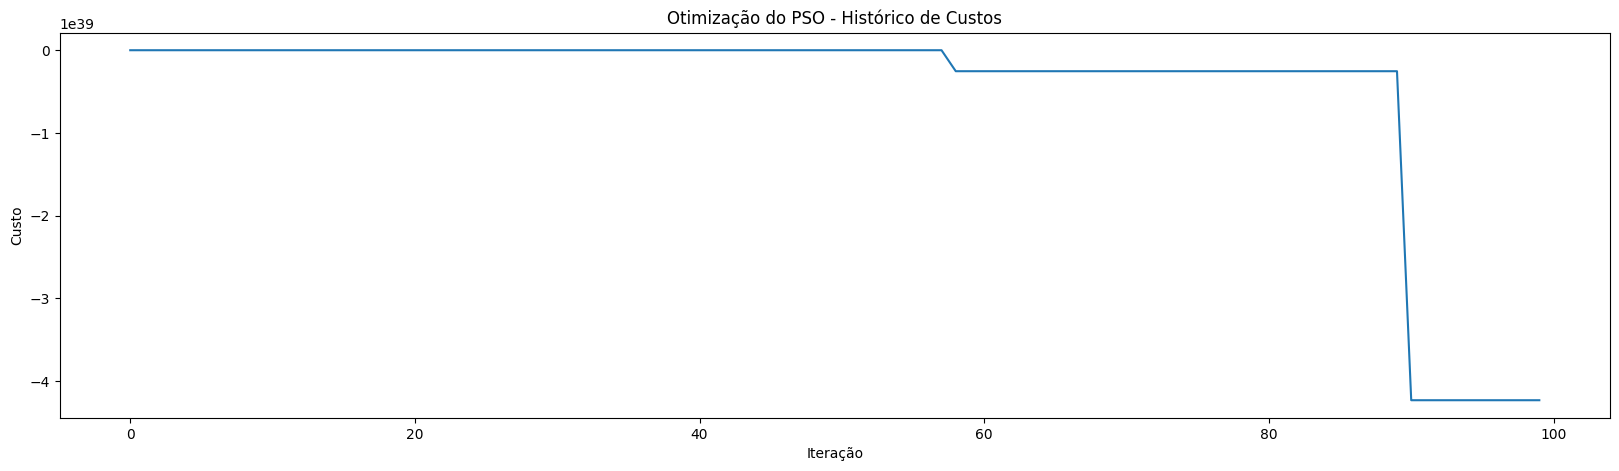

In [389]:
# Plotar gráfico de densidade da otimização
plt.figure(figsize=(20, 5))
plt.plot(cost_history)
plt.xlabel('Iteração')
plt.ylabel('Custo')
plt.title('Otimização do PSO - Histórico de Custos')
plt.show()

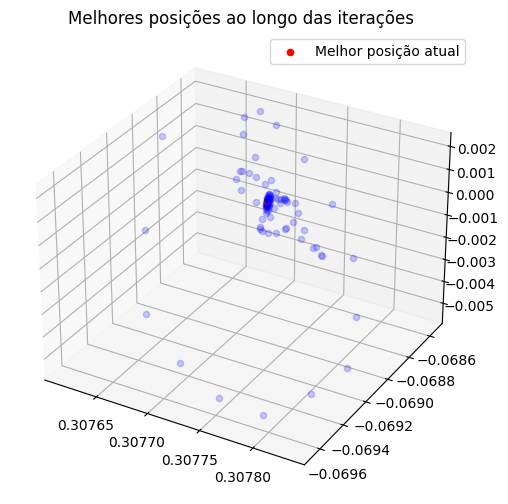

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 3
                              
Melhor custo: -4.2296033247939125e+39
Melhor custo pessoal (pbest) de cada partícula: -3.875173466346604e+38


In [390]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], best_positions[i, 2], c='blue', alpha=0.2)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], best_positions[-1, 2], c='red', label='Melhor posição atual')

ax.set_title('Melhores posições ao longo das iterações')
ax.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")

print("Melhor custo:", best_cost)
print("Melhor custo pessoal (pbest) de cada partícula:", pbest_cost[0])